# Which Anime Next? Recommendation System based on Content-based Filtering and Collaborative Filtering: Which Wins?

In [2]:
# import packages
import numpy as np
import pandas as pd
from pandas import Series
import seaborn as sns
import itertools
import os
import seaborn as sns
import re
import matplotlib.pyplot as plt

from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

from sklearn.preprocessing import MinMaxScaler


from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve,plot_precision_recall_curve,roc_curve,roc_auc_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

In [3]:
# import data: need to change path if used on another PC
df_anime = pd.read_csv("F:\\UCL\\Term2\\projects\\new\\data\\anime.csv")
df_anime_with_synopsis = pd.read_csv("F:\\UCL\\Term2\\projects\\new\\data\\anime_with_synopsis.csv")
df_animelist = pd.read_csv("F:\\UCL\\Term2\\projects\\new\\data\\animelist.csv")
df_watching_status = pd.read_csv("F:\\UCL\\Term2\\projects\\new\\data\\watching_status.csv")

In [4]:
# setting to show all columns of dataframes
pd.set_option("display.max_columns",None)

# 1. Data Preparation

In [5]:
# head of main dataset: df_anime
df_anime.head()

MAL_ID                             Name Score  \
0       1                     Cowboy Bebop  8.78   
1       5  Cowboy Bebop: Tengoku no Tobira  8.39   
2       6                           Trigun  8.24   
3       7               Witch Hunter Robin  7.27   
4       8                   Bouken Ou Beet  6.98   

                                             Genders            English name  \
0    Action, Adventure, Comedy, Drama, Sci-Fi, Space            Cowboy Bebop   
1              Action, Drama, Mystery, Sci-Fi, Space  Cowboy Bebop:The Movie   
2  Action, Sci-Fi, Adventure, Comedy, Drama, Shounen                  Trigun   
3  Action, Mystery, Police, Supernatural, Drama, ...      Witch Hunter Robin   
4          Adventure, Fantasy, Shounen, Supernatural  Beet the Vandel Buster   

                      Japanese name   Type Episodes  \
0                         カウボーイビバップ     TV       26   
1                    カウボーイビバップ 天国の扉  Movie        1   
2                             トライガン     TV       26   
3  Witch Hunter ROBIN (ウイッチハンターロビン)     TV       26   
4                            冒険王ビィト     TV       52   

                          Aired    Premiered  \
0   Apr 3, 1998 to Apr 24, 1999  Spring 1998   
1                   Sep 1, 2001      Unknown   
2   Apr 1, 1998 to Sep 30, 1998  Spring 1998   
3   Jul 2, 2002 to Dec 24, 2002  Summer 2002   
4  Sep 30, 2004 to Sep 29, 2005    Fall 2004   

                                           Producers  \
0                                      Bandai Visual   
1                             Sunrise, Bandai Visual   
2                               Victor Entertainment   
3  TV Tokyo, Bandai Visual, Dentsu, Victor Entert...   
4                                   TV Tokyo, Dentsu   

                              Licensors         Studios    Source  \
0      Funimation, Bandai Entertainment         Sunrise  Original   
1           Sony Pictures Entertainment           Bones  Original   
2  Funimation, Geneon Entertainment USA        Madhouse     Manga   
3      Funimation, Bandai Entertainment         Sunrise  Original   
4                               Unknown  Toei Animation     Manga   

          Duration                          Rating  Ranked  Popularity  \
0  24 min. per ep.  R - 17+ (violence & profanity)    28.0          39   
1    1 hr. 55 min.  R - 17+ (violence & profanity)   159.0         518   
2  24 min. per ep.       PG-13 - Teens 13 or older   266.0         201   
3  25 min. per ep.       PG-13 - Teens 13 or older  2481.0        1467   
4  23 min. per ep.                   PG - Children  3710.0        4369   

   Members  Favorites  Watching  Completed  On-Hold  Dropped  Plan to Watch  \
0  1251960      61971    105808     718161    71513    26678         329800   
1   273145       1174      4143     208333     1935      770          57964   
2   558913      12944     29113     343492    25465    13925         146918   
3    94683        587      4300      46165     5121     5378          33719   
4    13224         18       642       7314      766     1108           3394   

   Score-10   Score-9   Score-8  Score-7  Score-6 Score-5 Score-4 Score-3  \
0  229170.0  182126.0  131625.0  62330.0  20688.0  8904.0  3184.0  1357.0   
1   30043.0   49201.0   49505.0  22632.0   5805.0  1877.0   577.0   221.0   
2   50229.0   75651.0   86142.0  49432.0  15376.0  5838.0  1965.0   664.0   
3    2182.0    4806.0   10128.0  11618.0   5709.0  2920.0  1083.0   353.0   
4     312.0     529.0    1242.0   1713.0   1068.0   634.0   265.0    83.0   

  Score-2 Score-1  
0   741.0  1580.0  
1   109.0   379.0  
2   316.0   533.0  
3   164.0   131.0  
4    50.0    27.0

In [6]:
# show head of df_animelist
df_animelist.head()

user_id  anime_id  rating  watching_status  watched_episodes
0        0        67       9                1                 1
1        0      6702       7                1                 4
2        0       242      10                1                 4
3        0      4898       0                1                 1
4        0        21      10                1                 0

In [7]:
# show head of anime synopsis
df_anime_with_synopsis.head()

MAL_ID                             Name Score  \
0       1                     Cowboy Bebop  8.78   
1       5  Cowboy Bebop: Tengoku no Tobira  8.39   
2       6                           Trigun  8.24   
3       7               Witch Hunter Robin  7.27   
4       8                   Bouken Ou Beet  6.98   

                                             Genders  \
0    Action, Adventure, Comedy, Drama, Sci-Fi, Space   
1              Action, Drama, Mystery, Sci-Fi, Space   
2  Action, Sci-Fi, Adventure, Comedy, Drama, Shounen   
3  Action, Mystery, Police, Supernatural, Drama, ...   
4          Adventure, Fantasy, Shounen, Supernatural   

                                           sypnopsis  
0  In the year 2071, humanity has colonized sever...  
1  other day, another bounty—such is the life of ...  
2  Vash the Stampede is the man with a $$60,000,0...  
3  ches are individuals with special powers like ...  
4  It is the dark century and the people are suff...

array([[<AxesSubplot:title={'center':'MAL_ID'}>,
        <AxesSubplot:title={'center':'Popularity'}>,
        <AxesSubplot:title={'center':'Members'}>],
       [<AxesSubplot:title={'center':'Favorites'}>,
        <AxesSubplot:title={'center':'Watching'}>,
        <AxesSubplot:title={'center':'Completed'}>],
       [<AxesSubplot:title={'center':'On-Hold'}>,
        <AxesSubplot:title={'center':'Dropped'}>,
        <AxesSubplot:title={'center':'Plan to Watch'}>]], dtype=object)

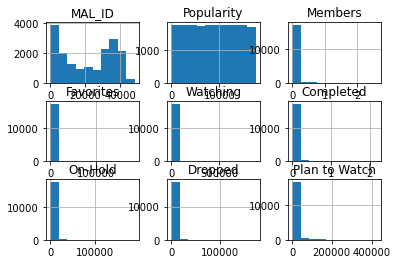

In [8]:
# check history of numerical variables
df_anime.hist()

## 1.1 Deal with Unknowns

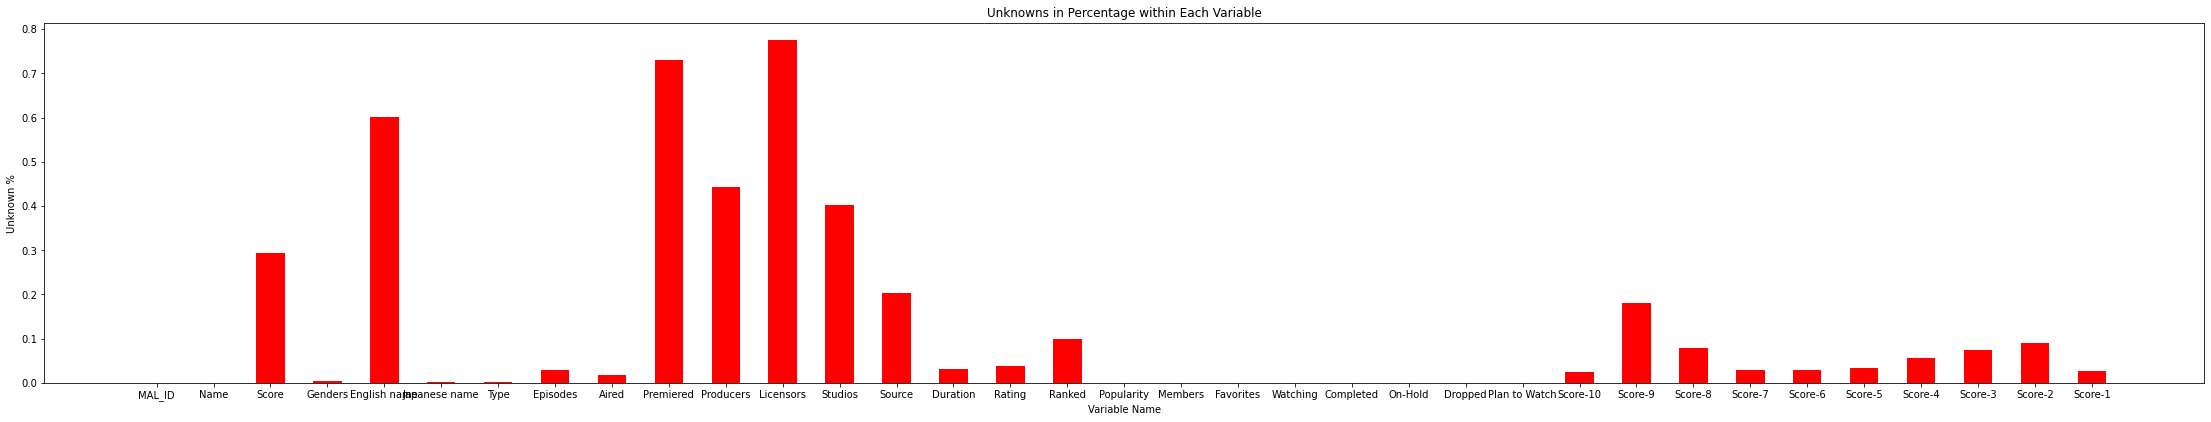

In [9]:
# count unknown variables
col_list=df_anime.columns
col_unknown_count_list=[]
for col in col_list:
    unknown_count=df_anime.loc[df_anime[col]=="Unknown",col].count()
    col_unknown_count_list.append(unknown_count/17562)

fig = plt.figure(figsize=(30,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(col_list,col_unknown_count_list,color="red",width=[0.5])

ax.set_xlabel('Variable Name')
ax.set_ylabel('Unknown %')
ax.set_title("Unknowns in Percentage within Each Variable")

plt.show()

### 1.1.1 Scores

In [10]:
# get sum and count for a numerical column, to facilitate avg calculation
def get_sum(col_name):
    sum_score = 0
    count_score = 0
    for each_value in df_anime[col_name]:
        #print(each_value)
        if each_value != 'Unknown':
            sum_score+=int(float(each_value))
        else:
            count_score+=1
    return sum_score,count_score


In [11]:
# test funciton
get_sum('Score-10')

(43603379, 437)

In [12]:
# fill in with avg score for each score vriable
df_anime['Score-10'] = np.where((df_anime['Score-10']=='Unknown'), get_sum('Score-10')[0]/get_sum('Score-10')[1], df_anime['Score-10'])
df_anime['Score-9'] = np.where((df_anime['Score-9']=='Unknown'), get_sum('Score-9')[0]/get_sum('Score-9')[1], df_anime['Score-9'])
df_anime['Score-8'] = np.where((df_anime['Score-8']=='Unknown'), get_sum('Score-8')[0]/get_sum('Score-8')[1], df_anime['Score-8'])
df_anime['Score-7'] = np.where((df_anime['Score-7']=='Unknown'), get_sum('Score-7')[0]/get_sum('Score-7')[1], df_anime['Score-7'])
df_anime['Score-6'] = np.where((df_anime['Score-6']=='Unknown'), get_sum('Score-6')[0]/get_sum('Score-6')[1], df_anime['Score-6'])
df_anime['Score-5'] = np.where((df_anime['Score-5']=='Unknown'), get_sum('Score-5')[0]/get_sum('Score-5')[1], df_anime['Score-5'])
df_anime['Score-4'] = np.where((df_anime['Score-4']=='Unknown'), get_sum('Score-4')[0]/get_sum('Score-4')[1], df_anime['Score-4'])
df_anime['Score-3'] = np.where((df_anime['Score-3']=='Unknown'), get_sum('Score-3')[0]/get_sum('Score-3')[1], df_anime['Score-3'])
df_anime['Score-2'] = np.where((df_anime['Score-2']=='Unknown'), get_sum('Score-2')[0]/get_sum('Score-2')[1], df_anime['Score-2'])
df_anime['Score-1'] = np.where((df_anime['Score-1']=='Unknown'), get_sum('Score-1')[0]/get_sum('Score-1')[1], df_anime['Score-1'])

In [13]:
# change score type to float
df_anime[['Score-10', 'Score-9','Score-8','Score-7','Score-6','Score-5','Score-4','Score-3','Score-2','Score-1']] = df_anime[[
    'Score-10', 'Score-9','Score-8','Score-7','Score-6','Score-5','Score-4','Score-3','Score-2','Score-1']].astype(float)

### 1.1.2 Type

In [14]:
# just use TV for all unknowns because it is the most frequent category
df_anime["Type"].value_counts()
df_anime["Type"]= np.where((df_anime['Type']=='Unknown'), "TV", df_anime['Type'])

### 1.1.3 Rating

In [15]:
# use G - All Ages for all unknowns
df_anime["Rating"].value_counts()
df_anime["Rating"]=np.where((df_anime['Rating']=='Unknown'), "G - All Ages", df_anime['Rating'])

### 1.1.4 Episodes

In [16]:
# unknowns in episodes represent anime which is still on-going, most likely
print("number of unknown episodes anime:",df_anime[df_anime['Episodes']=='Unknown'].count()[0])

# calculate avg episodes for types of anime
sub_data=df_anime[["Episodes","Type"]].copy()
sub_data = sub_data.loc[sub_data['Episodes'] != 'Unknown']
sub_data["Episodes"] = pd.to_numeric(sub_data["Episodes"])
sub_data.groupby(['Type']).mean()

number of unknown episodes anime: 516


Episodes
Type              
Movie     1.121132
Music     1.178718
ONA       8.916147
OVA       2.354973
Special   2.486758
TV       34.011402

In [17]:
# length of a movie is 1 episodes, makes sense, we will assign unknown episodes if their type is certain
# first assign movie and music to episode 1
df_anime['Episodes'] = np.where((df_anime['Type']=='Movie') 
                                      & (df_anime["Episodes"]=='Unknown'), 1, df_anime['Episodes'])
df_anime['Episodes'] = np.where((df_anime['Type']=='Music') 
                                      & (df_anime["Episodes"]=='Unknown'), 1, df_anime['Episodes'])
# ONA,OVA should be assined their avg
df_anime['Episodes'] = np.where((df_anime['Type']=='ONA') 
                                      & (df_anime["Episodes"]=='Unknown'), 9, df_anime['Episodes'])
df_anime['Episodes'] = np.where((df_anime['Type']=='OVA') 
                                      & (df_anime["Episodes"]=='Unknown'), 3, df_anime['Episodes'])
# special should be assign avg
df_anime['Episodes'] = np.where((df_anime['Type']=='Special') 
                                      & (df_anime["Episodes"]=='Unknown'), 2, df_anime['Episodes'])

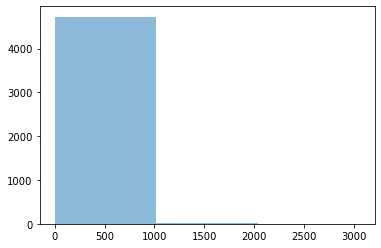

number of unknown episodes anime which are Tv type: 4736
[4.728e+03 7.000e+00 1.000e+00] [1.00000000e+00 1.01966667e+03 2.03833333e+03 3.05700000e+03] <BarContainer object of 3 artists>


In [18]:
# abit differnt in TV, since the distribution of TV is wide

# frequency distribution of TV episodes
sub_data_type = sub_data.loc[(sub_data['Episodes'] != 'Unknown') & (sub_data["Type"]=="TV")]
(n, bins, patches)= plt.hist(sub_data_type["Episodes"], bins=3,alpha=0.5)
plt.show()
print("number of unknown episodes anime which are Tv type:",len(sub_data_type["Episodes"]))
print(n,bins,patches)

# decide to use 800 as a break-up number and assign 800 to unknown episodes whose anime type is TV
df_anime['Episodes'] = np.where((df_anime['Type']=='TV') 
                                      & (df_anime["Episodes"]=='Unknown'), 800, df_anime['Episodes'])

### 1.1.5 Ranked

In [19]:
# calculate avg rank
sub_data_rank = df_anime["Ranked"].copy()
sub_data_rank = sub_data_rank.loc[sub_data_rank != 'Unknown']
print(sub_data_rank)
sub_data_rank = pd.to_numeric(sub_data_rank)
rank_mean=sub_data_rank.mean()

# fill in unknowns with avg
df_anime["Ranked"]=np.where((df_anime['Ranked']=='Unknown'), rank_mean, df_anime['Ranked'])

0           28.0
1          159.0
2          266.0
3         2481.0
4         3710.0
          ...   
17532    12882.0
17533    13980.0
17548        0.0
17552     5799.0
17556    12855.0
Name: Ranked, Length: 15800, dtype: object


### 1.1.6 Genders

In [20]:
# get rid of blank spaces
df_anime['Genders'] = df_anime['Genders'].str.replace(' ', '')
Genders_df=df_anime["Genders"].str.get_dummies(sep=",")
# print(Genders_df)

# the 5 most popular Genders
print(Genders_df.sum(axis=0).sort_values(ascending=False).head(5))

# add the 3 most popular genders to unknowns
df_anime["Genders"]=np.where((df_anime['Genders']=='Unknown'), "Comedy,Action,Fantasy", df_anime['Genders'])

Comedy       6029
Action       3888
Fantasy      3285
Adventure    2957
Kids         2665
dtype: int64


### 1.1.7 Aired

In [21]:
# print number of anime with unknown aired variable
print("there are",df_anime.loc[df_anime["Aired"]=="Unknown"].count()[1],"unknowns for aired")

# clean the aired to a specific year
df_anime['Aired'] = df_anime['Aired'].str.extract(r'(\d{4})')

# fill in unknowns with 2017, the most common year for aired
print(df_anime["Aired"].value_counts())
df_anime["Aired"]=np.where((df_anime['Aired']=='Unknown'), 2017, df_anime['Aired'])

there are 309 unknowns for aired
2017    922
2016    897
2018    882
2014    852
2015    792
       ... 
1953      2
1955      2
1937      2
1944      1
1945      1
Name: Aired, Length: 101, dtype: int64


### 1.1.8 Score

In [22]:
# fill in with avg
sub_data_score = df_anime["Score"].copy()
sub_data_score = sub_data_score.loc[sub_data_score != 'Unknown']
print(sub_data_score)
sub_data_score = pd.to_numeric(sub_data_score)
score_mean=sub_data_score.mean()
df_anime["Score"]=np.where((df_anime['Score']=='Unknown'), score_mean, df_anime['Score'])

0        8.78
1        8.39
2        8.24
3        7.27
4        6.98
         ... 
17504    6.59
17505    7.52
17512    6.83
17513    4.81
17552    6.52
Name: Score, Length: 12421, dtype: object


### 1.1.8 Source

In [23]:
# show the category distribution of source
print(df_anime["Source"].value_counts())

# fill in with most common category: original
df_anime["Source"]=np.where((df_anime['Source']=='Unknown'), "Original", df_anime['Source'])

Original         5215
Manga            3825
Unknown          3567
Visual novel      993
Game              880
Light novel       768
Other             597
Novel             510
Music             317
4-koma manga      288
Web manga         252
Picture book      147
Book              112
Card game          64
Digital manga      15
Radio              12
Name: Source, dtype: int64


### 1.1.9 Duration

In [24]:
#print(df_anime["Duration"][:50])
dur_dummy=df_anime["Duration"].str.split(" ")

# transfer the str and int combination string to integers in minutes to represent duration
clean_list=[]
for i in dur_dummy:
    #print(i)
    if i[0] !="Unknown":
        if len(i)==4:
            if (i[1]=="min.") & (i[0].isnumeric()) & (i[3]=="ep."):
                time_min=int(i[0])
            elif (i[0].isnumeric()) & (i[1]=="hr.") & (i[3]=="min."):
                time_min=int(i[0])*60+int(i[2])  
        else:
            if (i[0].isnumeric()) & (i[1]=="sec."):
                time_min=1
            elif (i[1]=="min.") & (i[0].isnumeric()):
                time_min=int(i[0])
    else:
        time_min="Unknown"
    clean_list.append(time_min)

In [25]:
clean_list.count("Unknown")
# assigned the transferred value to the "duration"
df_anime["Duration"]=clean_list

In [26]:
# select data containing only known values to see the trends
sub_data_dur=df_anime[["Duration","Type"]].copy()
sub_data_dur = sub_data_dur.loc[sub_data_dur['Duration'] != 'Unknown']
sub_data_dur["Duration"] = pd.to_numeric(sub_data_dur["Duration"])
sub_data_dur.groupby(['Type']).mean()

Duration
Type              
Movie    51.966724
Music     3.348392
ONA       8.255556
OVA      28.109759
Special  18.726115
TV       19.646016

In [27]:
# assign unknowns with the mean of the type 

df_anime['Duration'] = np.where((df_anime['Type']=='Movie') 
                                      & (df_anime["Duration"]=='Unknown'), 52, df_anime['Duration'])
df_anime['Duration'] = np.where((df_anime['Type']=='Music') 
                                      & (df_anime["Duration"]=='Unknown'), 3, df_anime['Duration'])
# ONA,OVA should be assined their avg
df_anime['Duration'] = np.where((df_anime['Type']=='ONA') 
                                      & (df_anime["Duration"]=='Unknown'), 8, df_anime['Duration'])
df_anime['Duration'] = np.where((df_anime['Type']=='OVA') 
                                      & (df_anime["Duration"]=='Unknown'), 28, df_anime['Duration'])
# special should be assign avg
df_anime['Duration'] = np.where((df_anime['Type']=='Special') 
                                      & (df_anime["Duration"]=='Unknown'), 19, df_anime['Duration'])
# TV should be assign avg
df_anime['Duration'] = np.where((df_anime['Type']=='TV') 
                                      & (df_anime["Duration"]=='Unknown'), 20, df_anime['Duration'])

### 1.1.10 Drop columns

In [28]:
# drop english name and japanses name since in name we have them all
df_anime_final = df_anime.drop(["English name","Japanese name"], 1)


## 1.2. Double check for missing values

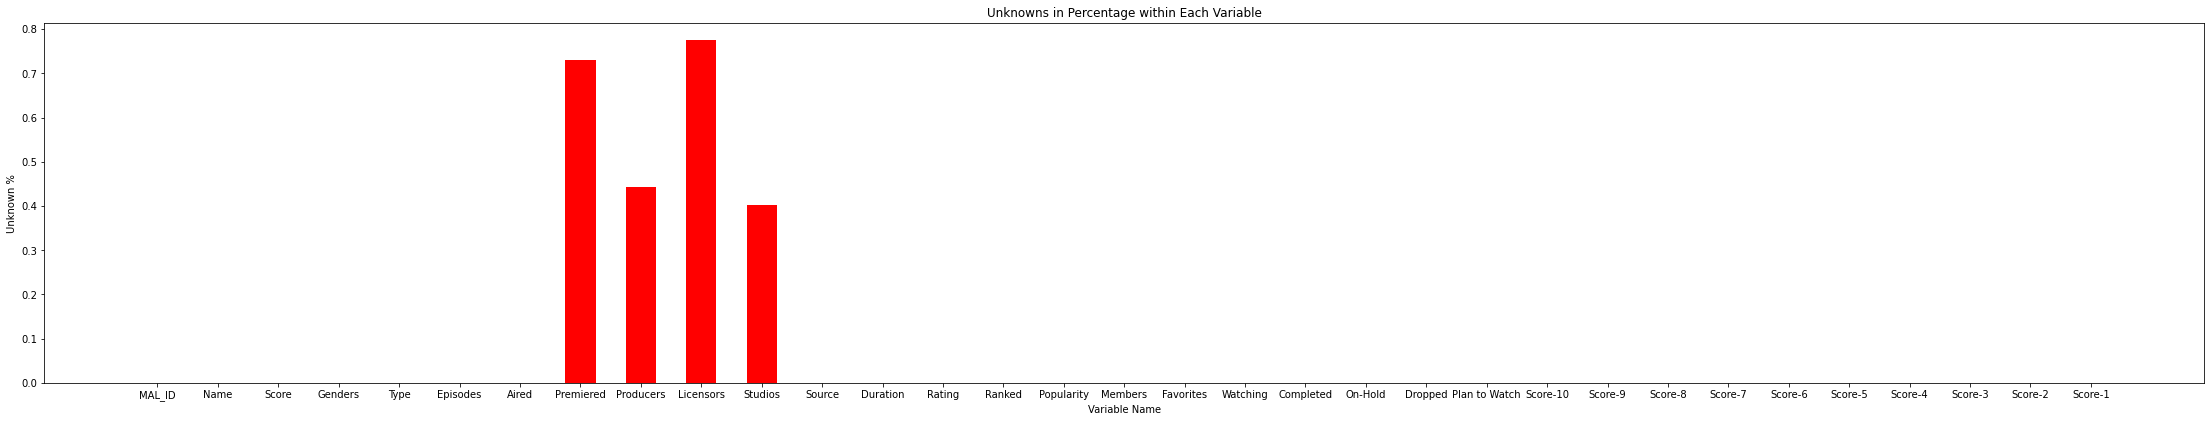

In [29]:
# again, count unknown
# for these 4 columns: Premiered,Producers,Licensors,Studios we still have unknowns
# but decide to keep them now since we have to use them in exploratory analysis and there is no better way to assign them values
col_list=df_anime_final.columns
col_unknown_count_list=[]
for col in col_list:
    unknown_count=df_anime_final.loc[df_anime_final[col]=="Unknown",col].count()
    col_unknown_count_list.append(unknown_count/17562)

fig = plt.figure(figsize=(30,5))
ax = fig.add_axes([0,0,1,1])
ax.bar(col_list,col_unknown_count_list,color="red",width=[0.5])

ax.set_xlabel('Variable Name')
ax.set_ylabel('Unknown %')
ax.set_title("Unknowns in Percentage within Each Variable")

plt.show()


In [30]:
# other manipulations: change type of score to numeric
df_anime_final["Score"] = pd.to_numeric(df_anime_final["Score"])

# 2. Data Exploration

This section will represent some interesting graphs/trends for this dataset.

## 2.1 Anime Analysis

In [31]:
# categorical plot function
def category_plot(cate_name,plot_title,figsize=(7,4),width=0.7):
    category_names=df_anime_final[cate_name].value_counts().index.tolist()
    count_list=[]
    for name in category_names:
        count_each_name=df_anime_final.loc[df_anime_final[cate_name]==name,cate_name].count()
        count_list.append(count_each_name)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0,0,1,1])
    ax.bar(category_names,count_list,width=width)
    
    ax.set_xlabel(cate_name)
    ax.set_ylabel("occurence count")
    ax.set_title(plot_title)
    plt.show()

### 2.1.1 Top 10 Anime

In [32]:
top10=df_anime_final[['Name', 'Score']].sort_values(by="Score",ascending=False).head(10)
print(top10)

                                       Name  Score
3971       Fullmetal Alchemist: Brotherhood   9.19
15926  Shingeki no Kyojin: The Final Season   9.17
5683                            Steins;Gate   9.11
6474                 Hunter x Hunter (2011)   9.10
14963    Shingeki no Kyojin Season 3 Part 2   9.10
9913                               Gintama°   9.10
6006                               Gintama'   9.08
741                    Ginga Eiyuu Densetsu   9.07
7261                    Gintama': Enchousen   9.04
9886                         Koe no Katachi   9.00


### 2.1.2 Most Discussed Anime

In [33]:
top10_discussed=df_anime_final[['Name', 'Members']].sort_values(by="Members",ascending=False).head(10)
print(top10_discussed)

                                   Name  Members
1393                         Death Note  2589552
7449                 Shingeki no Kyojin  2531397
3971   Fullmetal Alchemist: Brotherhood  2248456
6614                   Sword Art Online  2214395
10451                     One Punch Man  2123866
11185             Boku no Hero Academia  1909814
8646                        Tokyo Ghoul  1895488
10                               Naruto  1830540
5683                        Steins;Gate  1771162
8148                    No Game No Life  1751054


### 2.1.2 Most watched anime: completed watching

In [34]:
top10_comp=df_anime_final[['Name', 'Completed']].sort_values(by="Completed",ascending=False).head(10)
print(top10_comp)

                                   Name  Completed
7449                 Shingeki no Kyojin    2182587
1393                         Death Note    2146116
6614                   Sword Art Online    1907261
10451                     One Punch Man    1841220
11185             Boku no Hero Academia    1655900
3971   Fullmetal Alchemist: Brotherhood    1644938
8646                        Tokyo Ghoul    1594880
10                               Naruto    1462223
11308                    Kimi no Na wa.    1462143
8148                    No Game No Life    1426896


### 2.1.2 Most favorated anime

In [35]:
top10_fav=df_anime_final[['Name', 'Favorites']].sort_values(by="Favorites",ascending=False).head(10)
print(top10_fav)

                                   Name  Favorites
3971   Fullmetal Alchemist: Brotherhood     183914
5683                        Steins;Gate     148452
6474             Hunter x Hunter (2011)     147274
1393                         Death Note     145201
7449                 Shingeki no Kyojin     129844
11                            One Piece     126645
1431    Code Geass: Hangyaku no Lelouch      90487
1574                 Naruto: Shippuuden      84651
20              Neon Genesis Evangelion      71308
11308                    Kimi no Na wa.      71054


### 2.1.2 Top Anime Categories

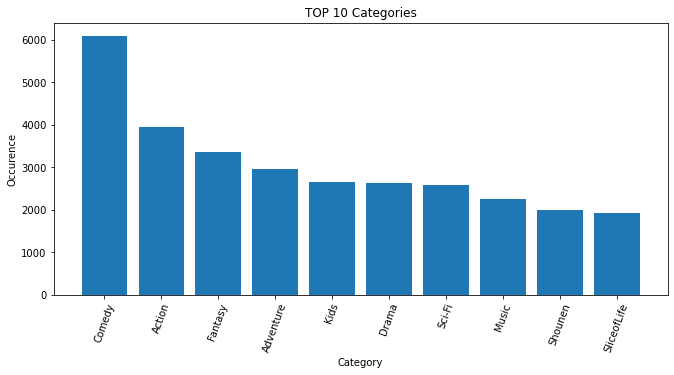

In [36]:
genders_s=df_anime_final["Genders"].str.get_dummies(sep=",")
genders_s=genders_s.sum(axis=0).sort_values(ascending=False)
genders_df=pd.DataFrame({'Category':genders_s.index, 'Occurence':genders_s.values})
genders_df=genders_df.sort_values(by="Occurence",ascending=False)


top10_genders=genders_df[['Category', 'Occurence']].head(10)
data = top10_genders["Occurence"]
labels = top10_genders["Category"]
plt.figure(figsize=(11,5))
plt.xticks(range(len(data)), labels)
plt.xlabel('Category')

plt.ylabel('Occurence')
plt.xticks(rotation=70)

plt.title('TOP 10 Categories')
plt.bar(range(len(data)), data) 
plt.show()

### 2.1.3 Top Anime Type

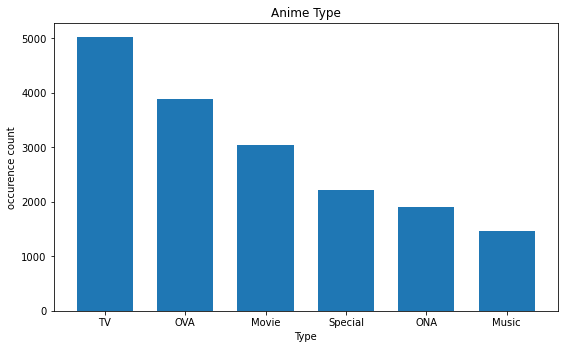

In [37]:
category_plot("Type","Anime Type")

### 2.1.4 Time of Aired

In [38]:
aired_s=df_anime_final["Aired"].value_counts()
aired_s=aired_s.sort_values()
aired_df=pd.DataFrame({'Year':aired_s.index, 'Occurance':aired_s.values})
# choose year after 1990
aired_df["Year"] = pd.to_numeric(aired_df["Year"])
aired_df=aired_df.loc[aired_df["Year"]>=1990]
aired_df=aired_df.sort_values(by="Year")

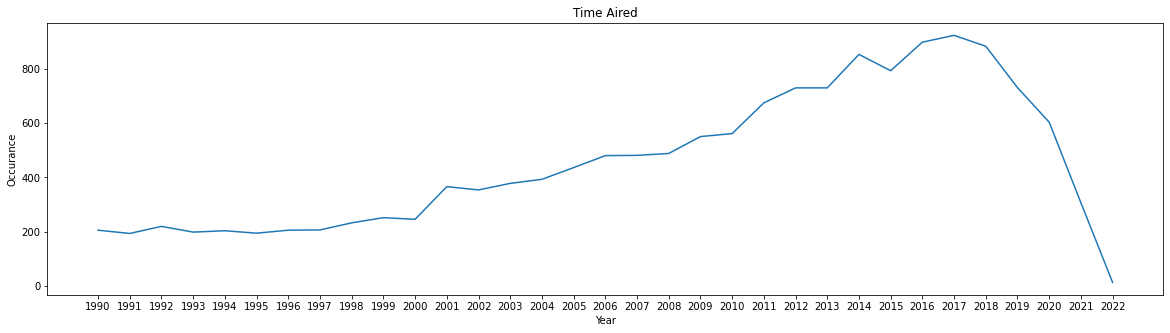

In [39]:
plt.figure(figsize=(20,5))
plt.plot(aired_df["Year"],aired_df["Occurance"])
plt.title('Time Aired')
plt.xlabel('Year')
plt.xticks(aired_df["Year"])
plt.ylabel('Occurance')
plt.show()

### 2.1.5 Top Producers/Licensors/Studios

Notice we have many unknowns for them, so the data is not completely categorizable; we only use the known values.

In [40]:
def cate_type2(col_name,title,occurance=False):
    producer_s=df_anime_final[col_name].value_counts()
    producer_s=producer_s.drop(labels=['Unknown'])
    producer_s=producer_s.sort_values()
    producer_df=pd.DataFrame({col_name:producer_s.index, 'Occurance':producer_s.values})
    # choose year after 1990
    producer_df["Occurance"] = pd.to_numeric(producer_df["Occurance"])
    if occurance:
        producer_df=producer_df.loc[producer_df["Occurance"]>=occurance]

    data = producer_df["Occurance"]
    labels = producer_df[col_name]
    plt.figure(figsize=(11,5))
    plt.xticks(range(len(data)), labels)
    plt.xlabel('Name')

    plt.ylabel('Occurance')
    plt.xticks(rotation=70)

    plt.title(title)

    plt.bar(range(len(data)), data) 
    plt.show()

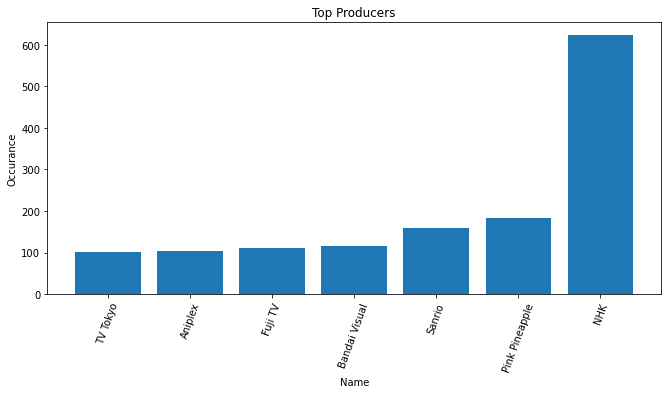

In [41]:
cate_type2("Producers","Top Producers",100)

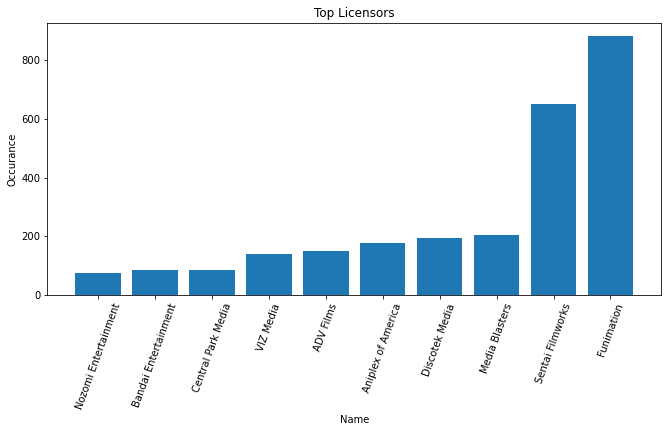

In [42]:
cate_type2("Licensors","Top Licensors",70)

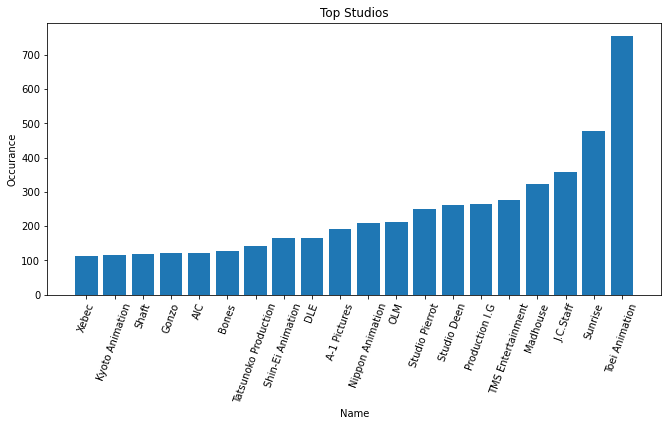

In [43]:
cate_type2("Studios","Top Studios",100)

### 2.1.5 Keywords in Anime

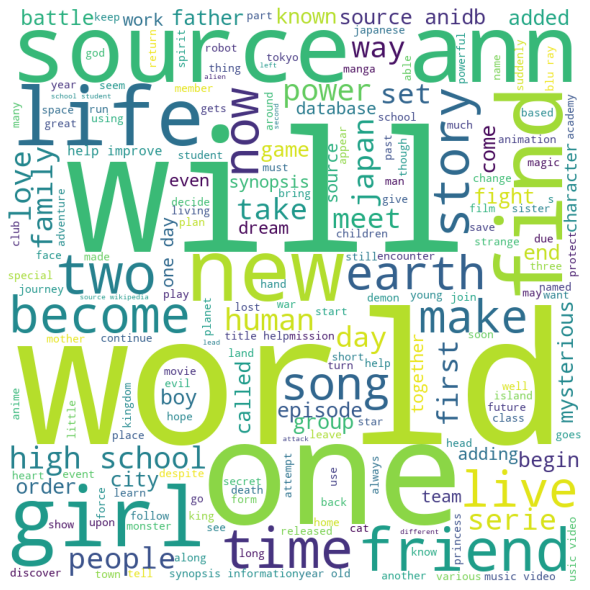

In [44]:
comment_words = ''
stopwords = set(STOPWORDS)
  
# iterate through the csv file
for val in df_anime_with_synopsis["sypnopsis"]:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
  
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()

## 2.2 User Analysis

### 2.2.1 User Watching Status

In [45]:
# rename variables
df_watching_status = df_watching_status.rename({'status': 'watching_status'}, axis=1) 

In [46]:
# print 
df_watching_status

watching_status         description
0                1  Currently Watching
1                2           Completed
2                3             On Hold
3                4             Dropped
4                6       Plan to Watch

In [47]:
# change variable type
df_animelist["user_id"] = pd.to_numeric(df_animelist["user_id"])

In [48]:
# decide to proceed with the first 100 users due to the large volumn of data
first_100_idx=df_animelist.loc[df_animelist["user_id"]==99].index[0]
df_merged_watching_filter=df_animelist[:first_100_idx+1]

In [49]:
# count each of the watching status for the first 100 user each
list_1=[]
list_2=[]
list_3=[]
list_4=[]
list_6=[]
for user in range(100):
    sub_df_user=df_merged_watching_filter.loc[df_merged_watching_filter['user_id']==user]
    count1=sub_df_user.loc[sub_df_user["watching_status"]==1].count()[0]
    count2=sub_df_user.loc[sub_df_user["watching_status"]==2].count()[0]
    count3=sub_df_user.loc[sub_df_user["watching_status"]==3].count()[0]
    count4=sub_df_user.loc[sub_df_user["watching_status"]==4].count()[0]
    count6=sub_df_user.loc[sub_df_user["watching_status"]==6].count()[0]
    list_1.append(count1)
    list_2.append(count2)
    list_3.append(count3)
    list_4.append(count4)
    list_6.append(count6)

In [50]:
list1_avg=sum(list_1)/len(list_1)
list2_avg=sum(list_2)/len(list_2)
list3_avg=sum(list_3)/len(list_3)
list4_avg=sum(list_4)/len(list_4)
list6_avg=sum(list_6)/len(list_6)
lists_avg=[list1_avg,list2_avg,list3_avg,list4_avg,list6_avg]
lists_name=["Currently Watching","Completed","On Hold","Dropped","Plan to Watch"]

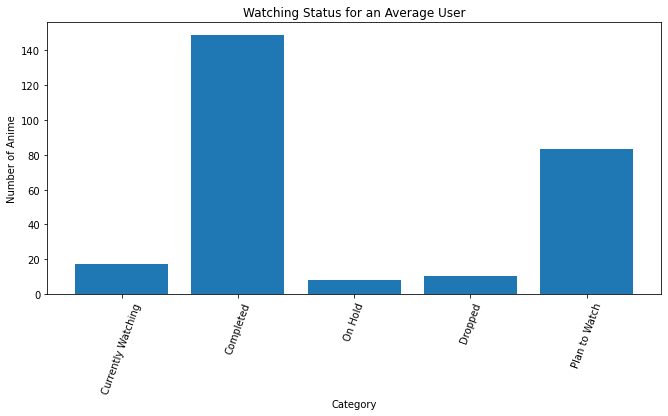

In [51]:
#plot bar
data = lists_avg
labels = lists_name
plt.figure(figsize=(11,5))
plt.xticks(range(len(data)), labels)
plt.xlabel('Category')

plt.ylabel('Number of Anime')
plt.xticks(rotation=70)

plt.title('Watching Status for an Average User')
plt.bar(range(len(data)), data) 
plt.show()

### 2.2.2 Episodes watched for each user/avg user

In [52]:
# histogram
list_eps=[]
for user in range(100):
    sub_df_user=df_merged_watching_filter.loc[df_merged_watching_filter['user_id']==user]
    sum_ep=int(sub_df_user["watched_episodes"].sum())
    count_ep=int(sub_df_user["watched_episodes"].count())
    if count_ep==0:
        list_eps.append(0)
    else:
        list_eps.append(sum_ep/count_ep)

Text(0.5, 0, '# of Episodes')

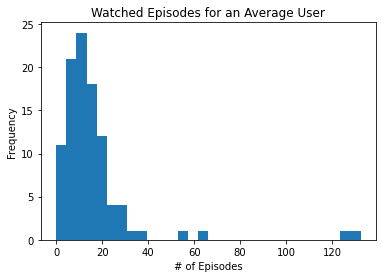

In [53]:
plt.hist(list_eps, density=False, bins=30)  
plt.title("Watched Episodes for an Average User")
plt.ylabel('Frequency')
plt.xlabel('# of Episodes')

## 2.3 Create New Feature --new score

In [54]:
# metrics to determine the top or popularity of anime
df_anime_final["new_score"] = (df_anime_final["Score-10"]*10+df_anime_final["Score-9"]*9+df_anime_final["Score-8"]*8+df_anime_final["Score-7"]*7+df_anime_final["Score-6"]*6+df_anime_final["Score-5"]*5
                         +df_anime_final["Score-4"]*4+df_anime_final["Score-3"]*3+df_anime_final["Score-2"]*2+df_anime_final["Score-1"]*1)/df_anime_final[["Score-10","Score-9","Score-8",
                                                                                                                      "Score-7","Score-6","Score-5","Score-4",
                                                                                                                      "Score-3","Score-2","Score-1"]].sum(axis=1)

In [55]:
#df_anime_final.head()

In [56]:
# now anime ranked with new score: weighted average
# rational：if a huge percent people give 10, then 10 should be weighted more
scored_anime = df_anime_final.sort_values('new_score', ascending=False)
scored_anime[['Name', 'new_score']].head(10)

Name  new_score
17226                                 Timeless Tree   9.998708
16914                                 The Third Eye   9.998477
17187                      Han Hua Ri Ji 2nd Season   9.998277
17447                                     Drawing!!   9.997946
16025  Kabushikigaisha G-anime Saiyou Concept Movie   9.997356
17506                              Kuiba Zhi Shu Tu   9.897355
17135                                     Spark Da!   9.848070
17146                                   Ton Ton Ton   9.848058
17436                             Don't Cry (Movie)   9.848048
17167                             Watashi no Nyanko   9.847990

# 3. Model Building

## 3.1 Content-based Filtering

Content-based filtering methods are based on a description of the item and a profile of the user's preferences. These methods are best suited to situations where there is known data on an item (name, location, description, etc.), but not on the user. Content-based recommenders treat recommendation as a user-specific classification problem and learn a classifier for the user's likes and dislikes based on an item's features.

In this system, keywords are used to describe the items and a user profile is built to indicate the type of item this user likes. In other words, these algorithms try to recommend items that are similar to those that a user liked in the past, or is examining in the present. It does not rely on a user sign-in mechanism to generate this often temporary profile. In particular, various candidate items are compared with items previously rated by the user and the best-matching items are recommended. 

### 3.1.1 Vector Space Model (using synopsis)

In [57]:
# we are going to use keywords from name,genders,sypnopsis to indicate similarity
df_anime_with_synopsis.head()

MAL_ID                             Name Score  \
0       1                     Cowboy Bebop  8.78   
1       5  Cowboy Bebop: Tengoku no Tobira  8.39   
2       6                           Trigun  8.24   
3       7               Witch Hunter Robin  7.27   
4       8                   Bouken Ou Beet  6.98   

                                             Genders  \
0    Action, Adventure, Comedy, Drama, Sci-Fi, Space   
1              Action, Drama, Mystery, Sci-Fi, Space   
2  Action, Sci-Fi, Adventure, Comedy, Drama, Shounen   
3  Action, Mystery, Police, Supernatural, Drama, ...   
4          Adventure, Fantasy, Shounen, Supernatural   

                                           sypnopsis  
0  In the year 2071, humanity has colonized sever...  
1  other day, another bounty—such is the life of ...  
2  Vash the Stampede is the man with a $$60,000,0...  
3  ches are individuals with special powers like ...  
4  It is the dark century and the people are suff...

In [58]:
df_anime_with_synopsis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16214 entries, 0 to 16213
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MAL_ID     16214 non-null  int64 
 1   Name       16214 non-null  object
 2   Score      16214 non-null  object
 3   Genders    16214 non-null  object
 4   sypnopsis  16206 non-null  object
dtypes: int64(1), object(4)
memory usage: 633.5+ KB


In [59]:
# Term Frequency-Inverse Document Frequency

# Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(df_anime_with_synopsis['sypnopsis'].values.astype('U'))

#Output the shape of tfidf_matrix: we have 45064 different vocabs, with total anime 16214
tfidf_matrix.shape

(16214, 45064)

In [60]:
tfidf_matrix

<16214x45064 sparse matrix of type '<class 'numpy.float64'>'
	with 488639 stored elements in Compressed Sparse Row format>

In [61]:
# check the vocabs
tfidf.get_feature_names()[1000:1010]

['achilles',
 'aching',
 'achingly',
 'achived',
 'acid',
 'acidman',
 'ackdam',
 'acker',
 'ackerman',
 'acking']

In [62]:
# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [63]:
cosine_sim

array([[1.        , 0.23139075, 0.0159667 , ..., 0.        , 0.00988169,
        0.04593121],
       [0.23139075, 1.        , 0.03702934, ..., 0.        , 0.        ,
        0.01297045],
       [0.0159667 , 0.03702934, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.00988169, 0.        , 0.        , ..., 0.        , 1.        ,
        0.01655197],
       [0.04593121, 0.01297045, 0.        , ..., 0.        , 0.01655197,
        1.        ]])

In [64]:
cosine_sim.shape

(16214, 16214)

In [65]:
cosine_sim[0]

array([1.        , 0.23139075, 0.0159667 , ..., 0.        , 0.00988169,
       0.04593121])

In [66]:
#Construct a reverse map of indices and anime titles
indices = pd.Series(df_anime_with_synopsis.index, index=df_anime_with_synopsis['Name']).drop_duplicates()

In [67]:
indices

Name
Cowboy Bebop                           0
Cowboy Bebop: Tengoku no Tobira        1
Trigun                                 2
Witch Hunter Robin                     3
Bouken Ou Beet                         4
                                   ...  
Daomu Biji Zhi Qinling Shen Shu    16209
Mieruko-chan                       16210
Higurashi no Naku Koro ni Sotsu    16211
Yama no Susume: Next Summit        16212
Scarlet Nexus                      16213
Length: 16214, dtype: int64

In [68]:
# Function that takes in anime name as input and outputs most similar anime
def get_recommendations(name,num_to_rec,cosine_sim=cosine_sim):
    # Get the index of the name that matches the title
    idx = indices[name]

    # Get the pairwsie similarity scores of all anime with that anime
    sim_scores = list(enumerate(cosine_sim[idx]))
    # print(sim_scores)

    # Sort the anime based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    #print(sim_scores)

    # Get the scores of the n most similar anime
    sim_scores = sim_scores[1:num_to_rec+1]

    # Get the anime indices
    anime_indices = [i[0] for i in sim_scores]

    # Return the top 5 most similar anime
    return df_anime_with_synopsis['Name'].iloc[anime_indices]

In [69]:
# test
get_recommendations("Naruto",5) # name of anime, number of anime to recommend

1508                                    Naruto: Shippuuden
11346                      Boruto: Naruto Next Generations
6158            Naruto: Shippuuden Movie 6 - Road to Ninja
3103     Naruto: Shippuuden - Shippuu! "Konoha Gakuen" Den
8831                              Boruto: Naruto the Movie
Name: Name, dtype: object

#### 3.1.1.1 Setting for Evaluation

In [70]:
# prepare dataset for evaluation
df_animelist.head()
df_anime_with_synopsis = df_anime_with_synopsis.rename({'MAL_ID': 'anime_id'}, axis=1)  
df_anime_final = df_anime_final.rename({'MAL_ID': 'anime_id'}, axis=1)  

In [71]:
df_all_anime=df_anime_with_synopsis[[ "anime_id","Name"]]

In [72]:
# decide to proceed with the first 500 users due to the large volumn of data
fist_500_idx=df_animelist.loc[df_animelist["user_id"]==500].index[0]
df_animelist_fist500=df_animelist[:fist_500_idx-1]

In [73]:
df_user_anime=pd.merge(df_animelist_fist500,df_all_anime, on = 'anime_id')
df_user_anime=pd.merge(df_user_anime,df_anime_final, on ="anime_id")

In [74]:
df_user_anime=df_user_anime.sort_values(by="user_id").reset_index(drop=True)
df_user_anime.head()

user_id  anime_id  rating  watching_status  watched_episodes  \
0        0        67       9                1                 1   
1        0       431       8                2                 1   
2        0      2762       9                2                24   
3        0       570       7                2                 1   
4        0      3418       9                2                50   

                        Name_x                       Name_y  Score  \
0  Basilisk: Kouga Ninpou Chou  Basilisk: Kouga Ninpou Chou   7.58   
1          Howl no Ugoku Shiro          Howl no Ugoku Shiro   8.67   
2               Igano Kabamaru               Igano Kabamaru   7.87   
3                      Jin-Rou                      Jin-Rou   7.79   
4      Jungle no Ouja Taa-chan      Jungle no Ouja Taa-chan   7.01   

                                             Genders   Type Episodes Aired  \
0  Action,Adventure,Historical,Supernatural,Roman...     TV       24  2005   
1                    Adventure,Drama,Fantasy,Romance  Movie        1  2004   
2     Action,Adventure,Comedy,Romance,School,Shounen     TV       24  1983   
3        Military,Police,Psychological,Drama,Romance  Movie        1  2000   
4                               Action,Comedy,Parody     TV       50  1993   

     Premiered                              Producers  \
0  Spring 2005  GDH, Kodansha, Sotsu Music Publishing   
1      Unknown                d-rights, Tokuma Shoten   
2    Fall 1983                                   Toho   
3      Unknown                                Unknown   
4    Fall 1993                               TV Tokyo   

                              Licensors         Studios Source Duration  \
0                            Funimation           Gonzo  Manga       24   
1                   Walt Disney Studios   Studio Ghibli  Novel      119   
2                               Unknown       Group TAC  Manga       23   
3  Bandai Entertainment, Discotek Media  Production I.G  Manga      102   
4                               Unknown       Group TAC  Manga       24   

                           Rating  Ranked  Popularity  Members  Favorites  \
0  R - 17+ (violence & profanity)  1325.0         940   156661       1467   
1                    G - All Ages    51.0          98   847414      17845   
2       PG-13 - Teens 13 or older   715.0        5153     8759        121   
3  R - 17+ (violence & profanity)   846.0        1181   124856       1359   
4                R+ - Mild Nudity  3616.0        9094     1805         14   

   Watching  Completed  On-Hold  Dropped  Plan to Watch  Score-10   Score-9  \
0      6964      82153     6380     6957          54207    6677.0   11140.0   
1      8733     754791     2283      947          80660  186983.0  167309.0   
2       360       4192      317      374           3516     768.0     589.0   
3      3005      72439     1078      612          47722    6381.0   11407.0   
4       130        486       96      123            970      55.0      58.0   

    Score-8  Score-7  Score-6  Score-5  Score-4  Score-3  Score-2  Score-1  \
0   19570.0  17421.0   7816.0   3800.0   1554.0    643.0    316.0    244.0   
1  137336.0  62317.0  18427.0   6427.0   2246.0    737.0    351.0    668.0   
2     839.0    654.0    340.0    157.0     52.0     42.0     23.0     35.0   
3   18187.0  13046.0   5051.0   2131.0    826.0    288.0    131.0    113.0   
4      77.0     92.0     62.0     21.0     19.0     10.0     10.0      6.0   

   new_score  
0   7.523077  
1   8.692126  
2   7.862532  
3   7.796859  
4   7.173171

In [75]:
df_user_anime = df_user_anime.rename({'Name_x': 'Name'}, axis=1) 

In [76]:
df_user_anime = df_user_anime.drop(["Name_y"], 1)

In [77]:
df_user_anime_features=df_user_anime[["user_id","anime_id","Name","rating","watching_status","watched_episodes","Score",
                            "Episodes","Aired","Duration","Ranked","Popularity","Members",
                            "Favorites","Watching","Completed","On-Hold","Dropped","Plan to Watch","new_score"]]

In [78]:
anime_features_for_each_user=df_user_anime_features.copy()
                          # the rest do not include because encoded types shape do not match the testing data
                                        #df_user_anime["Genders"].str.get_dummies(sep=","),
                          #pd.get_dummies(df_user_anime["Type"]),
                          #pd.get_dummies(df_user_anime["Source"])],axis=1)

In [79]:
# final combianed user data and anime data table
anime_features_for_each_user.head()

user_id  anime_id                         Name  rating  watching_status  \
0        0        67  Basilisk: Kouga Ninpou Chou       9                1   
1        0       431          Howl no Ugoku Shiro       8                2   
2        0      2762               Igano Kabamaru       9                2   
3        0       570                      Jin-Rou       7                2   
4        0      3418      Jungle no Ouja Taa-chan       9                2   

   watched_episodes  Score Episodes Aired Duration  Ranked  Popularity  \
0                 1   7.58       24  2005       24  1325.0         940   
1                 1   8.67        1  2004      119    51.0          98   
2                24   7.87       24  1983       23   715.0        5153   
3                 1   7.79        1  2000      102   846.0        1181   
4                50   7.01       50  1993       24  3616.0        9094   

   Members  Favorites  Watching  Completed  On-Hold  Dropped  Plan to Watch  \
0   156661       1467      6964      82153     6380     6957          54207   
1   847414      17845      8733     754791     2283      947          80660   
2     8759        121       360       4192      317      374           3516   
3   124856       1359      3005      72439     1078      612          47722   
4     1805         14       130        486       96      123            970   

   new_score  
0   7.523077  
1   8.692126  
2   7.862532  
3   7.796859  
4   7.173171

In [80]:
def get_anime_for_user(user_id):
    new_df=df_user_anime.loc[df_user_anime["user_id"]==user_id]
    #print("user",user_id,"has watched",len(new_df["Name"]),"anime!")
    return new_df["Name"].tolist()

# get anime list for anime that a user doesnt like: criteria: dropped anime and anime below rating of 6
def get_dislike_anime(user_id):
    average_rating= 6 
    dislike_df=df_user_anime.loc[(df_user_anime["user_id"]==user_id)]
    dislike_df=dislike_df.loc[(df_user_anime["watching_status"]==4) | (df_user_anime["rating"]<average_rating)]

    return dislike_df["Name"].tolist()

# define functions to get the relevant anime for a user
def relevant_anime_for_user(user_id):
    anime_list = get_anime_for_user(user_id)
    #print(anime_list)
    dislike_list = get_dislike_anime(user_id)
    #print(dislike_list)
    relevant_list = [anime for anime in anime_list if anime not in dislike_list]
    return relevant_list

In [81]:
# start off by assigning 0 to column 'liked'
anime_features_for_each_user["Liked"]=0

In [82]:
# new column: mark 1 for all liked anime for each user
for i in range(500):
    for rel_anime in relevant_anime_for_user(i):
        #print(rel_anime)
        index_liked=df_user_anime[(df_user_anime["user_id"]==i) & (df_user_anime["Name"]==rel_anime)].index.values.astype(int)
        # print(index_liked)
        anime_features_for_each_user.loc[index_liked, 'Liked'] = 1                          

In [83]:
# see like and dislike split in the training dataset
anime_features_for_each_user["Liked"].value_counts()

0    77763
1    70078
Name: Liked, dtype: int64

In [84]:
# get recommendation list for a user: for anime that deeemed relevant to a user, recommend anime to him
def recommendation_list(user_id):
    list_to_walk_thr=relevant_anime_for_user(user_id)
    #print(list_to_walk_thr)
    rec_list =[]
    count=0
    for anime in list_to_walk_thr:
        try:
            alist=get_recommendations(anime,10).tolist()
            count+=1
        #print(count)
        #print(alist)
            rec_list.append(alist)
        # handle errors
        except:
            #print("failed")
            pass
    #print(count)
    #print(rec_list)
    flattened_list = [val for sublist in rec_list for val in sublist]
    # print(len(flattened_list),"anime has been recommended")
    # set removes duplicaed recommendations
    return set(flattened_list)

In [85]:
# test the outcome of the function
list(recommendation_list(1))[:10]

['Hello Kitty no Yuki no Joou',
 'Hunter x Hunter: Greed Island',
 'Shippuu! Iron Leaguer',
 'Re:Petit kara Hajimeru Isekai Seikatsu',
 'No.6',
 'One Piece: Romance Dawn Story',
 'Kizumonogatari I: Tekketsu-hen',
 "Cat's Eye",
 'Yu☆Gi☆Oh! The Dark Side of Dimensions',
 'Mouse']

#### 3.1.1.2 Model Selection: 3-fold cross validation

#### logistic regression

In [86]:
# porform cross validation on first 100 sample users
precision_containor_cv=[]
recall_containor_cv=[]
f1_containor_cv=[]
for i in range(100):
    target_df_user=anime_features_for_each_user.loc[anime_features_for_each_user["user_id"]==i]
    # drop air since it has nan, drop rating, watching statues and episodes since these are related to user not anime itself
    target_df_user_final=target_df_user.drop(["rating","watching_status","watched_episodes","Aired"], 1)
    x_train=target_df_user_final[target_df_user_final.columns[3:-1]]
    y_train=target_df_user_final["Liked"]

    try:    
        norm = MinMaxScaler().fit(x_train)
        # transform training data
        x_transformed = norm.transform(x_train)


        # logistic classifier
        clf_logistic=LogisticRegression(random_state=42,max_iter=8000) # increase the max iteration or it will fail to converge
        # logistic regression: 10-fold cv
        pred_log=cross_val_predict(clf_logistic,x_transformed,y_train,cv=3)
        pre_logistic=precision_score(y_train,pred_log)
        recall_logistic=recall_score(y_train,pred_log)
        f1_logistic=f1_score(y_train,pred_log)
        
        # add cv score to lists
        precision_containor_cv.append(pre_logistic)
        recall_containor_cv.append(recall_logistic)
        f1_containor_cv.append(f1_logistic)

    except Exception as e:
        #print(e)
        pass

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predic

In [121]:
# get rid of 0
precision_containor_cv=[x for x in precision_containor_cv if x!=0]
recall_containor_cv=[x for x in recall_containor_cv if x!=0]
f1_containor_cv=[x for x in f1_containor_cv if x!=0]

precision_final_log=sum(precision_containor_cv)/len(precision_containor_cv)
recall_final_log=sum(recall_containor_cv)/len(recall_containor_cv)
f1_final_log=sum(f1_containor_cv)/len(f1_containor_cv)
print(precision_final_log,recall_final_log,f1_final_log)

0.6746876030323176 0.7090003715648148 0.6590388773104608


#### decision tree

In [122]:
# porform cross validation on first 100 sample users
precision_containor_tree=[]
recall_containor_tree=[]
f1_containor_tree=[]
for i in range(100):
    target_df_user=anime_features_for_each_user.loc[anime_features_for_each_user["user_id"]==i]
    # drop air since it has nan, drop rating, watching statues and episodes since these are related to user not anime itself
    target_df_user_final=target_df_user.drop(["rating","watching_status","watched_episodes","Aired"], 1)
    x_train=target_df_user_final[target_df_user_final.columns[3:-1]]
    y_train=target_df_user_final["Liked"]

    try:    
        norm = MinMaxScaler().fit(x_train)
        # transform training data
        x_transformed = norm.transform(x_train)


        # logistic classifier
        clf_tree = DecisionTreeClassifier(random_state=42) 
        # logistic regression: 10-fold cv
        pred_tree=cross_val_predict(clf_tree,x_transformed,y_train,cv=3)
        pre_tree=precision_score(y_train,pred_tree)
        recall_tree=recall_score(y_train,pred_tree)
        f1_tree=f1_score(y_train,pred_log)
        
        # add cv score to lists
        precision_containor_tree.append(pre_tree)
        recall_containor_tree.append(recall_tree)
        f1_containor_tree.append(f1_tree)

    except Exception as e:
        #print(e)
        pass

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

In [123]:
# get rid of 0
precision_containor_tree=[x for x in precision_containor_tree if x!=0]
recall_containor_tree=[x for x in recall_containor_tree if x!=0]
f1_containor_tree=[x for x in f1_containor_tree if x!=0]

precision_final_tree=sum(precision_containor_tree)/len(precision_containor_tree)
recall_final_tree=sum(recall_containor_tree)/len(recall_containor_tree)
f1_final_tree=sum(f1_containor_tree)/len(f1_containor_tree)
print(precision_final_tree,recall_final_tree,f1_final_tree)

0.6666666666666666 0.5833333333333334 0.5714285714285715


#### support vector machine

In [124]:
# porform cross validation on first 100 sample users
precision_containor_svc=[]
recall_containor_svc=[]
f1_containor_svc=[]
for i in range(100):
    target_df_user=anime_features_for_each_user.loc[anime_features_for_each_user["user_id"]==i]
    # drop air since it has nan, drop rating, watching statues and episodes since these are related to user not anime itself
    target_df_user_final=target_df_user.drop(["rating","watching_status","watched_episodes","Aired"], 1)
    x_train=target_df_user_final[target_df_user_final.columns[3:-1]]
    y_train=target_df_user_final["Liked"]

    try:    
        norm = MinMaxScaler().fit(x_train)
        # transform training data
        x_transformed = norm.transform(x_train)


        # logistic classifier
        clf_svc = LinearSVC(random_state=42) 
        # logistic regression: 10-fold cv
        pred_svc=cross_val_predict(clf_tree,x_transformed,y_train,cv=3)
        pre_svc=precision_score(y_train,pred_svc)
        recall_svc=recall_score(y_train,pred_svc)
        f1_svc=f1_score(y_train,pred_svc)
        
        # add cv score to lists
        precision_containor_svc.append(pre_svc)
        recall_containor_svc.append(recall_svc)
        f1_containor_svc.append(f1_svc)

    except Exception as e:
        #print(e)
        pass

D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(res

In [125]:
# get rid of 0
precision_containor_svc=[x for x in precision_containor_svc if x!=0]
recall_containor_svc=[x for x in recall_containor_svc if x!=0]
f1_containor_svc=[x for x in f1_containor_svc if x!=0]

precision_final_svc=sum(precision_containor_svc)/len(precision_containor_svc)
recall_final_svc=sum(recall_containor_svc)/len(recall_containor_svc)
f1_final_svc=sum(f1_containor_svc)/len(f1_containor_svc)
print(precision_final_svc,recall_final_svc,f1_final_svc)

0.6463001811424754 0.6424084929136081 0.6435913973264247


#### kneighborclassifier

In [126]:
# porform cross validation on first 100 sample users
precision_containor_kn=[]
recall_containor_kn=[]
f1_containor_kn=[]
for i in range(100):
    target_df_user=anime_features_for_each_user.loc[anime_features_for_each_user["user_id"]==i]
    # drop air since it has nan, drop rating, watching statues and episodes since these are related to user not anime itself
    target_df_user_final=target_df_user.drop(["rating","watching_status","watched_episodes","Aired"], 1)
    x_train=target_df_user_final[target_df_user_final.columns[3:-1]]
    y_train=target_df_user_final["Liked"]

    try:    
        norm = MinMaxScaler().fit(x_train)
        # transform training data
        x_transformed = norm.transform(x_train)


        # logistic classifier
        clf_kn = KNeighborsClassifier() 
        # logistic regression: 10-fold cv
        pred_kn=cross_val_predict(clf_kn,x_transformed,y_train,cv=3)
        pre_kn=precision_score(y_train,pred_kn)
        recall_kn=recall_score(y_train,pred_kn)
        f1_kn=f1_score(y_train,pred_kn)
        
        # add cv score to lists
        precision_containor_kn.append(pre_kn)
        recall_containor_kn.append(recall_kn)
        f1_containor_kn.append(f1_kn)

    except Exception as e:
        #print(e)
        pass

D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
D:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(("The least populated class in y has only %d"
D:\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [127]:
# get rid of 0
precision_containor_kn=[x for x in precision_containor_kn if x!=0]
recall_containor_kn=[x for x in recall_containor_kn if x!=0]
f1_containor_kn=[x for x in f1_containor_kn if x!=0]

precision_final_kn=sum(precision_containor_kn)/len(precision_containor_kn)
recall_final_kn=sum(recall_containor_kn)/len(recall_containor_kn)
f1_final_kn=sum(f1_containor_kn)/len(f1_containor_kn)
print(precision_final_kn,recall_final_kn,f1_final_kn)

0.6503842242333043 0.67277878732066 0.6532520776188653


#### CV comparison

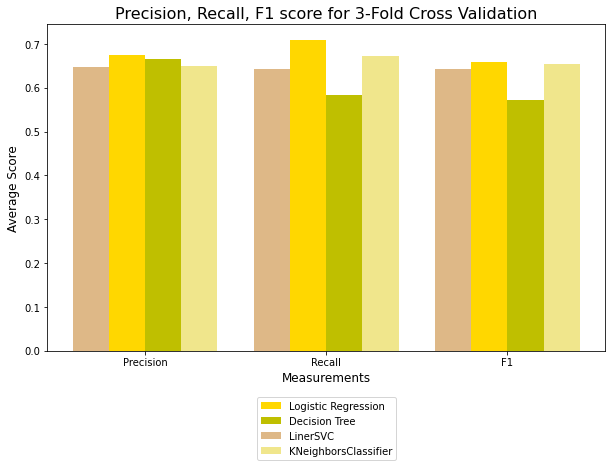

In [128]:
# fix number of neighbours to 5
log_all=[precision_final_log,recall_final_log,f1_final_log]
tree_all=[precision_final_tree,recall_final_tree,f1_final_tree]
svc_all=[precision_final_svc,recall_final_svc,f1_final_svc]
kn_all=[precision_final_kn,recall_final_kn,f1_final_kn]


# plot figure
plt.figure(figsize=(10,6))

x_axis_name = ["Precision","Recall","F1"]

X_axis = np.arange(len(x_axis_name))
  
plt.bar(X_axis - 0.1, log_all, 0.2, label = 'Logistic Regression',color="gold")
plt.bar(X_axis + 0.1, tree_all, 0.2, label = 'Decision Tree',color="y")
plt.bar(X_axis - 0.3, svc_all, 0.2, label = 'LinerSVC',color="burlywood")
plt.bar(X_axis + 0.3, kn_all, 0.2, label = 'KNeighborsClassifier',color="khaki")

plt.xticks(X_axis, x_axis_name)
plt.xlabel("Measurements",fontsize=12)
plt.ylabel("Average Score",fontsize=12)
plt.title("Precision, Recall, F1 score for 3-Fold Cross Validation",fontsize=16)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.35))

fig.subplots_adjust(bottom=0.25)
plt.show()

#### 3.1.1.3 MAP

In [87]:
precision_containor=[]
position_containor_cbv=[]
for i in range(100):
    target_df_user=anime_features_for_each_user.loc[anime_features_for_each_user["user_id"]==i]
    # drop air since it has nan, drop rating, watching statues and episodes since these are related to user not anime itself
    target_df_user_final=target_df_user.drop(["rating","watching_status","watched_episodes","Aired"], 1)
    x_train=target_df_user_final[target_df_user_final.columns[3:-1]]
    y_train=target_df_user_final["Liked"]

    # data normalization with sklearn
    # fit scaler on training data
    # print("NAN check",x_train.isna().any())
    try:    
        norm = MinMaxScaler().fit(x_train)
        # transform training data
        x_transformed = norm.transform(x_train)

        """might need to change to other classifier in the future"""
        # logistic classifier
        clf_logistic=LogisticRegression(random_state=42,max_iter=8000) # increase the max iteration or it will fail to converge
        # logistic regression: accuracy
        # score_logistic=cross_val_score(clf_logistic,x_transformed,y_train,cv=5,scoring="accuracy")
        # decision tree: accuracy
        # score_log=cross_val_score(clf_logistic,x_transformed,y_train,cv=5,scoring="accuracy")
        # print(score_log)
        # confusion matrix
        # pred_log=cross_val_predict(clf_logistic,x_transformed,y_train,cv=5)
        #print(confusion_matrix(y_train,pred_log))

        # fit model
        clf_logistic.fit(x_transformed, y_train)
        # create empty data frame to add on recommended anime for a user
        rec_df_for_user = pd.DataFrame()
        #print(recommendation_list(i)
        
        
        # here to change the number of anime to show: we test 10, 20, 30
        for rec_anime in list(recommendation_list(i))[:10]:
            #print(rec_anime)
            a_row=df_anime_final.loc[df_anime_final["Name"]==rec_anime]
            #print(a_row)
            rec_df_for_user=rec_df_for_user.append(a_row)
            #print(rec_df_for_user)
        #print(rec_df_for_user)
        x_test=rec_df_for_user[['Score', 'Episodes', 'Duration', 'Ranked', 'Popularity',
               'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
               'Plan to Watch', 'new_score']]

        x_test_ransformed = norm.transform(x_test)
        test_pred=clf_logistic.predict(x_test_ransformed)
        #print(test_pred)
        pred_y=test_pred.tolist()
        position_containor_cbv.append(pred_y)
        precision_score1=sum(pred_y)/len(pred_y)
        precision_containor.append(precision_score1)
    except Exception as e:
        #print(e)
        pass

In [88]:
# if we recommend 5 anime per animie a user like, we get like 42% precision
print("avg precision",sum(precision_containor)/len(precision_containor))

avg precision 0.42045454545454536


#### 3.1.1.5 Focused MAP

In [89]:
# test accuracy: fix position to 3
pos_three_cbv=[x[:3] for x in position_containor_cbv]
acccuracy_three_cbv=[sum(y)/3 for y in pos_three_cbv]
print("accuracy when only looking at first 3 posistion: ", sum(acccuracy_three_cbv)/len(acccuracy_three_cbv))

accuracy when only looking at first 3 posistion:  0.40909090909090917


In [90]:
# test accuracy: fix position to 5
pos_five_cbv=[x[:5] for x in position_containor_cbv]
acccuracy_five_cbv=[sum(y)/5 for y in pos_five_cbv]
print("accuracy when only looking at first 5 posistion: ", sum(acccuracy_five_cbv)/len(acccuracy_five_cbv))

accuracy when only looking at first 5 posistion:  0.42500000000000004


### 3.1.2 Vector Space Model (using 'gender'+'synoposis')

In [134]:
# change from object to string
df_anime_with_synopsis['Genders'] = df_anime_with_synopsis['Genders'].astype('str') 
df_anime_with_synopsis['sypnopsis'] = df_anime_with_synopsis['sypnopsis'].astype('str') 


In [135]:
# convert each string element to list
all_list=[]
for each_value in df_anime_with_synopsis['Genders']:
    each_list = each_value.split(",")
    # print(each_list)
    # decide to keep the top 3 gender
    each_list = each_list[:3]
    # print(each_list)
    all_list.append(each_list)


In [136]:
# print(all_list)
df_anime_with_synopsis['Genders']=all_list

In [138]:
df_anime_with_synopsis['Genders']

0               [Action,  Adventure,  Comedy]
1                  [Action,  Drama,  Mystery]
2               [Action,  Sci-Fi,  Adventure]
3                 [Action,  Mystery,  Police]
4             [Adventure,  Fantasy,  Shounen]
                         ...                 
16209    [Adventure,  Mystery,  Supernatural]
16210        [Comedy,  Horror,  Supernatural]
16211           [Mystery,  Dementia,  Horror]
16212    [Adventure,  Slice of Life,  Comedy]
16213                      [Action,  Fantasy]
Name: Genders, Length: 16214, dtype: object

In [139]:
def get_clear_string():
    clean_list = []
    for i in df_anime_with_synopsis['Genders']:
        clean_list.append(' '.join(i) )
        
    return clean_list

In [140]:
df_anime_with_synopsis['clean_genders']=get_clear_string()
df_anime_with_synopsis['soup']=df_anime_with_synopsis['clean_genders']+" "+df_anime_with_synopsis['sypnopsis']

In [142]:
# Term Frequency-Inverse Document Frequency

# Define a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf_1 = TfidfVectorizer(stop_words='english')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix_1 = tfidf_1.fit_transform(df_anime_with_synopsis['soup'].values.astype('U'))

#Output the shape of tfidf_matrix: we have 45064 different vocabs, with total anime 16214
tfidf_matrix_1.shape

(16214, 45065)

In [143]:
# Compute the cosine similarity matrix
cosine_sim_1 = linear_kernel(tfidf_matrix_1, tfidf_matrix_1)

In [144]:
#Construct a reverse map of indices and anime titles
indices = pd.Series(df_anime_with_synopsis.index, index=df_anime_with_synopsis['Name']).drop_duplicates()

In [145]:
get_recommendations("Naruto",5,cosine_sim_1)

1508                                    Naruto: Shippuuden
11346                      Boruto: Naruto Next Generations
6158            Naruto: Shippuuden Movie 6 - Road to Ninja
3103     Naruto: Shippuuden - Shippuu! "Konoha Gakuen" Den
8831                              Boruto: Naruto the Movie
Name: Name, dtype: object

The reason that the 2 methods generate similar results:

TF-IDF takes into consideration the relative frequency of a vocab among different anime. However, the vocab that occurs in every anime is not important to distinguish the documents. 
For example, genres like action would not make a huge different because it appears in most anime.
Since we are choosing 3 genres for each anime, and the total genre types are not very significantly different or distinct between each anime, the resulting of combining gender to synoposis is not that different from the initial methods using synoposis only.

So for later analysis, we will use synoposis only.


### 3.1.3. Nearest Neighbor Model

Besides utilizing the vector space technique to understand similarities with document angles using anime descriptions, another way to understand similarity is by using Euclidean distance between anime using features other than plain text. Nearest Neighbor algorithm is introduced here as another approach: it finds the k number of points (or anime) closes to a certain data point (or anime). 

In [159]:
# new df with info that we need for knn
df_knn=df_anime_final[["anime_id","Name","new_score","Genders","Type","Episodes","Aired","Duration","Rating","Ranked","Popularity","Members",
         "Watching","Completed","On-Hold","Dropped","Plan to Watch"]].copy()
df_knn.head(2)

anime_id                             Name  new_score  \
0         1                     Cowboy Bebop   8.740248   
1         5  Cowboy Bebop: Tengoku no Tobira   8.390985   

                                      Genders   Type Episodes Aired Duration  \
0  Action,Adventure,Comedy,Drama,Sci-Fi,Space     TV       26  1998       24   
1           Action,Drama,Mystery,Sci-Fi,Space  Movie        1  2001      115   

                           Rating Ranked  Popularity  Members  Watching  \
0  R - 17+ (violence & profanity)   28.0          39  1251960    105808   
1  R - 17+ (violence & profanity)  159.0         518   273145      4143   

   Completed  On-Hold  Dropped  Plan to Watch  
0     718161    71513    26678         329800  
1     208333     1935      770          57964

In [160]:
# select feature
anime_features1=df_knn[["new_score","Episodes","Popularity","Members","Watching","Completed","On-Hold","Dropped","Plan to Watch"]].copy()

In [161]:
df_knn.head()

anime_id                             Name  new_score  \
0         1                     Cowboy Bebop   8.740248   
1         5  Cowboy Bebop: Tengoku no Tobira   8.390985   
2         6                           Trigun   8.215289   
3         7               Witch Hunter Robin   7.216657   
4         8                   Bouken Ou Beet   6.892115   

                                          Genders   Type Episodes Aired  \
0      Action,Adventure,Comedy,Drama,Sci-Fi,Space     TV       26  1998   
1               Action,Drama,Mystery,Sci-Fi,Space  Movie        1  2001   
2    Action,Sci-Fi,Adventure,Comedy,Drama,Shounen     TV       26  1998   
3  Action,Mystery,Police,Supernatural,Drama,Magic     TV       26  2002   
4          Adventure,Fantasy,Shounen,Supernatural     TV       52  2004   

  Duration                          Rating  Ranked  Popularity  Members  \
0       24  R - 17+ (violence & profanity)    28.0          39  1251960   
1      115  R - 17+ (violence & profanity)   159.0         518   273145   
2       24       PG-13 - Teens 13 or older   266.0         201   558913   
3       25       PG-13 - Teens 13 or older  2481.0        1467    94683   
4       23                   PG - Children  3710.0        4369    13224   

   Watching  Completed  On-Hold  Dropped  Plan to Watch  
0    105808     718161    71513    26678         329800  
1      4143     208333     1935      770          57964  
2     29113     343492    25465    13925         146918  
3      4300      46165     5121     5378          33719  
4       642       7314      766     1108           3394

In [162]:
# featrues already for knn
anime_features=pd.concat([anime_features1,
                          df_knn["Genders"].str.get_dummies(sep=","),
                          pd.get_dummies(df_knn["Type"]),
                          pd.get_dummies(df_knn["Rating"])],axis=1)
anime_features.head()

new_score Episodes  Popularity  Members  Watching  Completed  On-Hold  \
0   8.740248       26          39  1251960    105808     718161    71513   
1   8.390985        1         518   273145      4143     208333     1935   
2   8.215289       26         201   558913     29113     343492    25465   
3   7.216657       26        1467    94683      4300      46165     5121   
4   6.892115       52        4369    13224       642       7314      766   

   Dropped  Plan to Watch  Action  Adventure  Cars  Comedy  Dementia  Demons  \
0    26678         329800       1          1     0       1         0       0   
1      770          57964       1          0     0       0         0       0   
2    13925         146918       1          1     0       1         0       0   
3     5378          33719       1          0     0       0         0       0   
4     1108           3394       0          1     0       0         0       0   

   Drama  Ecchi  Fantasy  Game  Harem  Hentai  Historical  Horror  Josei  \
0      1      0        0     0      0       0           0       0      0   
1      1      0        0     0      0       0           0       0      0   
2      1      0        0     0      0       0           0       0      0   
3      1      0        0     0      0       0           0       0      0   
4      0      0        1     0      0       0           0       0      0   

   Kids  Magic  MartialArts  Mecha  Military  Music  Mystery  Parody  Police  \
0     0      0            0      0         0      0        0       0       0   
1     0      0            0      0         0      0        1       0       0   
2     0      0            0      0         0      0        0       0       0   
3     0      1            0      0         0      0        1       0       1   
4     0      0            0      0         0      0        0       0       0   

   Psychological  Romance  Samurai  School  Sci-Fi  Seinen  Shoujo  ShoujoAi  \
0              0        0        0       0       1       0       0         0   
1              0        0        0       0       1       0       0         0   
2              0        0        0       0       1       0       0         0   
3              0        0        0       0       0       0       0         0   
4              0        0        0       0       0       0       0         0   

   Shounen  ShounenAi  SliceofLife  Space  Sports  SuperPower  Supernatural  \
0        0          0            0      1       0           0             0   
1        0          0            0      1       0           0             0   
2        1          0            0      0       0           0             0   
3        0          0            0      0       0           0             1   
4        1          0            0      0       0           0             1   

   Thriller  Vampire  Yaoi  Yuri  Movie  Music  ONA  OVA  Special  TV  \
0         0        0     0     0      0      0    0    0        0   1   
1         0        0     0     0      1      0    0    0        0   0   
2         0        0     0     0      0      0    0    0        0   1   
3         0        0     0     0      0      0    0    0        0   1   
4         0        0     0     0      0      0    0    0        0   1   

   G - All Ages  PG - Children  PG-13 - Teens 13 or older  \
0             0              0                          0   
1             0              0                          0   
2             0              0                          1   
3             0              0                          1   
4             0              1                          0   

   R - 17+ (violence & profanity)  R+ - Mild Nudity  Rx - Hentai  
0                               1                 0            0  
1                               1                 0            0  
2                               0                 0            0  
3                               0                 0            0  
4                             

In [163]:
# scaling

min_max_scaler = MinMaxScaler()
anime_features = min_max_scaler.fit_transform(anime_features)


In [164]:
# it is just the first step of knn, thus not a supervised learning task
# here we recommend 5 anime, n_neighbor=6
nbrs = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(anime_features)

distances, indexes = nbrs.kneighbors(anime_features)

In [165]:
def get_index_from_name(name):
    return df_knn[df_knn["Name"]==name].index.tolist()[0]


all_anime_names = list(df_knn.Name.values)

In [166]:

# search for similar animes both by name
def print_similar_animes(name=None):
    found_id = get_index_from_name(name)
    anime_list_rec=[]
    for id_in in indexes[found_id][1:]:
        anime_list_rec.append(df_knn.loc[id_in]["Name"])
    return anime_list_rec

In [167]:
print_similar_animes("Naruto")

['Naruto: Shippuuden',
 'Dragon Ball Z',
 'Dragon Ball Super',
 'Boruto: Naruto Next Generations',
 'Dragon Ball Kai']

In [168]:
# get recommendation list for a user
def recommendation_list_knn(user_id):
    list_to_walk_thr=relevant_anime_for_user(user_id)
    #print(list_to_walk_thr)
    rec_list =[]
    count=0
    for anime in list_to_walk_thr:
        try:
            alist=print_similar_animes(anime)
            rec_list.append(alist)
        # handle errors
        except:
            #print("failed")
            pass
    #print(count)
    #print(rec_list)
    flattened_list = [val for sublist in rec_list for val in sublist]
    # print(len(flattened_list),"anime has been recommended")
    # set removes duplicaed recommendations
    return set(flattened_list)

#### 3.1.3.1 MAP

In [101]:
precision_containor_knn=[]
position_containor_nn=[]
for i in range(100):
    target_df_user=anime_features_for_each_user.loc[anime_features_for_each_user["user_id"]==i]
    # drop air since it has nan, drop rating, watching statues and episodes since these are related to user not anime itself
    target_df_user_final=target_df_user.drop(["rating","watching_status","watched_episodes","Aired"], 1)
    x_train=target_df_user_final[target_df_user_final.columns[3:-1]]
    y_train=target_df_user_final["Liked"]

    # data normalization with sklearn
    # fit scaler on training data
    # print("NAN check",x_train.isna().any())
    try:    
        norm = MinMaxScaler().fit(x_train)
        # transform training data
        x_transformed = norm.transform(x_train)

        """might need to change to other classifier in the future"""
        # logistic classifier
        clf_logistic=LogisticRegression(random_state=42,max_iter=8000) # increase the max iteration or it will fail to converge
        # logistic regression: accuracy
        # score_logistic=cross_val_score(clf_logistic,x_transformed,y_train,cv=5,scoring="accuracy")
        # decision tree: accuracy
        # score_log=cross_val_score(clf_logistic,x_transformed,y_train,cv=5,scoring="accuracy")
        # print(score_log)
        # confusion matrix
        # pred_log=cross_val_predict(clf_logistic,x_transformed,y_train,cv=5)
        #print(confusion_matrix(y_train,pred_log))

        # fit model
        clf_logistic.fit(x_transformed, y_train)
        # create empty data frame to add on recommended anime for a user
        rec_df_for_user = pd.DataFrame()
        #print(recommendation_list(i))
        for rec_anime in list(recommendation_list_knn(i))[:10]:
            #print(rec_anime)
            a_row=df_anime_final.loc[df_anime_final["Name"]==rec_anime]
            #print(a_row)
            rec_df_for_user=rec_df_for_user.append(a_row)
            #print(rec_df_for_user)
        #print(rec_df_for_user)
        x_test=rec_df_for_user[['Score', 'Episodes', 'Duration', 'Ranked', 'Popularity',
               'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
               'Plan to Watch', 'new_score']]

        x_test_ransformed = norm.transform(x_test)
        test_pred=clf_logistic.predict(x_test_ransformed)
        #print(test_pred)
        pred_y=test_pred.tolist()
        position_containor_nn.append(pred_y)
        precision_score2=sum(pred_y)/len(pred_y)
        precision_containor_knn.append(precision_score2)
    except Exception as e:
        #print(e)
        pass

In [102]:
# if we recommend 1 anime per animie a user like, we get like 56% precision
print("avg precision",sum(precision_containor_knn)/len(precision_containor_knn))
print("active sample users are:",len(precision_containor_knn))

avg precision 0.5045454545454544
active sample users are: 88


#### 3.1.3.2 Focused MAP

In [103]:
# test accuracy: fix position to 3
pos_three_nn=[x[:3] for x in position_containor_nn]
acccuracy_three_nn=[sum(y)/3 for y in pos_three_nn]
print("accuracy when only looking at first 3 posistion: ", sum(acccuracy_three_nn)/len(acccuracy_three_nn))

accuracy when only looking at first 3 posistion:  0.4621212121212121


In [104]:
# test accuracy: fix position to 5
pos_five_nn=[x[:5] for x in position_containor_nn]
acccuracy_five_nn=[sum(y)/5 for y in pos_five_nn]
print("accuracy when only looking at first 5 posistion: ", sum(acccuracy_five_nn)/len(acccuracy_five_nn))

accuracy when only looking at first 5 posistion:  0.4840909090909092


## 3.2 Collaborative Filtering

### 3.2.1. User-based Collaborative Filtering

As its name suggests, user-based approach first understands the similarity between users. Then, the anime which scores high among top N similar users will be recommended. The below section will illustrate the rationale behind thoroughly.

In [105]:
# the dataset we use here
df_animelist.head()

user_id  anime_id  rating  watching_status  watched_episodes
0        0        67       9                1                 1
1        0      6702       7                1                 4
2        0       242      10                1                 4
3        0      4898       0                1                 1
4        0        21      10                1                 0

In [106]:
df_animelist["rating"].value_counts()

0     46827035
8     15422150
7     14244633
9     10235934
6      7543377
10     7144392
5      4029645
4      1845854
3       905700
2       545339
1       480688
Name: rating, dtype: int64

In [107]:
# check avg number of rating per user
import statistics
ratings_per_user = df_animelist.groupby('user_id')['rating'].count()
statistics.mean(ratings_per_user.tolist())

335.2817846947233

<AxesSubplot:>

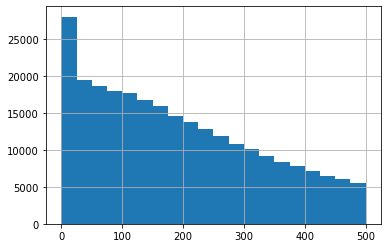

In [108]:
# distribution of ratings per user: many rating less than 100 anime
ratings_per_user.hist(bins=20, range=(0,500))

In [109]:
### use only the first 100 users only （for precision analysis）
first_1000_idx=df_animelist.loc[df_animelist["user_id"]==1000].index[0]
df_animelist_first1000=df_animelist[:first_1000_idx]

In [110]:
# Matrix: # of rows users; # of columns for anime
rating_matrix = df_animelist_first1000.pivot_table(index='user_id', columns='anime_id', values='rating')
# replace NaN values with 0
rating_matrix = rating_matrix.fillna(0)
# display the top few rows
rating_matrix.head(10)

anime_id  1      5      6      7      8      15     16     17     18     \
user_id                                                                   
0           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2           0.0    0.0    0.0    0.0    0.0    9.0    0.0    0.0    0.0   
3           9.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    8.0   
4           0.0    0.0    0.0    0.0    0.0    0.0    9.0    0.0    0.0   
5           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6           6.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
7           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
9           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

anime_id  19     20     21     22     23     24     25     26     27     \
user_id                                                                   
0           0.0    0.0   10.0    0.0    0.0    9.0    0.0    0.0    0.0   
1           9.0   10.0    9.0    9.0    0.0    0.0    0.0    0.0    0.0   
2           0.0    9.0    9.0    9.0    0.0    0.0    0.0    0.0    0.0   
3           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5           0.0    0.0    0.0    0.0    0.0   10.0    0.0    0.0    0.0   
6           0.0    5.0    0.0    5.0    0.0    0.0    0.0    0.0    0.0   
7           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
9           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

anime_id  28     29     30     31     32     33     43     44     45     \
user_id                                                                   
0           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3           0.0    0.0    8.0    0.0    0.0    0.0    8.0    0.0    0.0   
4           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6           0.0    0.0    8.0    0.0    9.0    0.0    9.0    0.0    0.0   
7           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8           0.0    0.0    9.0    8.0    0.0    0.0    0.0    0.0    0.0   
9           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

anime_id  46     47     48     49     50     51     52     53     54     \
user_id                                                                   
0           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3           0.0    9.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
4           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
5           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
6           0.0    0.0    0.0    0.0    0.0    7.0    0.0    0.0    7.0   
7           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
9           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

anime_id  55     56     57     58     59     60     61     62     63     \
user_id                                                                   
0           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
1           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
2           0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
3           0.0    0.

In [111]:
# find similar users using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
import operator
# find the top 3 similar users by cosine similarity
def similar_users(user_id, matrix, k=3):
    # create a df of just the current user
    user = matrix[matrix.index == user_id]
    
    # and a df of all other users
    other_users = matrix[matrix.index != user_id]
    
    # calc cosine similarity between user and each other user
    similarities = cosine_similarity(user,other_users)[0].tolist()
    
    # create list of indices of these users
    indices = other_users.index.tolist()
    
    # create key/values pairs of user index and their similarity
    index_similarity = dict(zip(indices, similarities))
    
    # sort by similarity
    index_similarity_sorted = sorted(index_similarity.items(), key=operator.itemgetter(1))
    index_similarity_sorted.reverse()
    
    # grab k users off the top
    top_users_similarities = index_similarity_sorted[:k]
    #print(top_users_similarities)
    users = [u[0] for u in top_users_similarities]
    indices_u=[u[1] for u in top_users_similarities]
    
    return users,indices_u

In [112]:
# test this for user 0
current_user=0
similar_user_indices = similar_users(current_user, rating_matrix,3)
print(similar_user_indices)

([521, 530, 247], [0.28358645668342636, 0.21902816515890028, 0.21279261377905342])


In [113]:
# recommendation example: 5 neighbors
def recommend_item_cf_user_5(user_index, similar_user_indices, matrix, items=10):
    
    # load vectors for similar users
    similar_users = matrix[matrix.index.isin(similar_user_indices[0])]
    similar_users=pd.DataFrame(similar_users, index=[similar_user_indices[0][0],similar_user_indices[0][1],similar_user_indices[0][2],
                                                    similar_user_indices[0][3],similar_user_indices[0][4]])
    #real_dis=[(1-x) for x in similar_user_indices[1]]
    total_distance=sum(similar_user_indices[1])
    #print(similar_users)
    #print(total_distance)
    dis_div_total_distance=[x/total_distance for x in similar_user_indices[1]]
    dis_div_total_distance = Series({similar_user_indices[0][0]:dis_div_total_distance[0],
                 similar_user_indices[0][1]:dis_div_total_distance[1],
                 similar_user_indices[0][2]:dis_div_total_distance[2],
                                    similar_user_indices[0][3]:dis_div_total_distance[3],
                                    similar_user_indices[0][4]:dis_div_total_distance[4]})
    #print(dis_div_total_distance)
    # calc weighted avg ratings across the 3 similar users
    #print(type(similar_users))
    similar_users = similar_users.mul(dis_div_total_distance,axis=0)
    #print(similar_users)
    similar_users = similar_users.sum(axis=0)
    # convert to dataframe so its easy to sort and filter
    similar_users_df = pd.DataFrame(similar_users, columns=['mean'])
    #print(similar_users_df)
    
    # load vector for the current user
    user_df = matrix[matrix.index == user_index]
    # transpose it so its easier to filter
    user_df_transposed = user_df.transpose()
    # rename the column as 'rating'
    user_df_transposed.columns = ['rating']
    # remove any rows without a 0 value. Anime not watched yet
    user_df_transposed = user_df_transposed[user_df_transposed['rating']==0]
    # generate a list of animes the user has not seen
    animes_unseen = user_df_transposed.index.tolist()
    
    # filter avg ratings of similar users for only anime the current user has not seen
    similar_users_df_filtered = similar_users_df[similar_users_df.index.isin(animes_unseen)]
    # order the dataframe
    similar_users_df_ordered = similar_users_df.sort_values(by=['mean'], ascending=False)
    # grab the top n anime   
    top_n_anime = similar_users_df_ordered.head(items)
    top_n_anime_indices = top_n_anime.index.tolist()
    # lookup these anime in the other dataframe to find names
    anime_information = df_anime_final[df_anime_final['anime_id'].isin(top_n_anime_indices)]
    
    return anime_information["Name"] #items

In [114]:
# combined function to output recommended top 5 anime
def find_anime_cf_user(user_id,k,output_n): # k = number of similar users; output_n = number of anime to reccomend
    similar_user_indices=similar_users(user_id, rating_matrix, k) # k= number of similar users
    # item = number of anime to recommend
    output_anime=recommend_item_cf_user_5(user_id, similar_user_indices, rating_matrix, output_n)
    return output_anime
    
    

In [115]:
# print top 10 recommendation when choosing 5 neighbors
find_anime_cf_user(0,5,10)

100               Fullmetal Alchemist
142                     Mononoke Hime
176     Sen to Chihiro no Kamikakushi
202                        Elfen Lied
404               Howl no Ugoku Shiro
537          Kaze no Tani no Nausicaä
1393                       Death Note
1535            Byousoku 5 Centimeter
2049            Toki wo Kakeru Shoujo
2646              Gake no Ue no Ponyo
Name: Name, dtype: object

#### 3.2.1.1 MAP

In [116]:
precision_containor_cf_user=[]
position_containor_ub=[]
for i in range(100):
    target_df_user=anime_features_for_each_user.loc[anime_features_for_each_user["user_id"]==i]
    # drop air since it has nan, drop rating, watching statues and episodes since these are related to user not anime itself
    target_df_user_final=target_df_user.drop(["rating","watching_status","watched_episodes","Aired"], 1)
    x_train=target_df_user_final[target_df_user_final.columns[3:-1]]
    y_train=target_df_user_final["Liked"]

    # data normalization with sklearn
    # fit scaler on training data
    # print("NAN check",x_train.isna().any())

    try:  
        norm = MinMaxScaler().fit(x_train)
        # transform training data
        x_transformed = norm.transform(x_train)
        # logistic classifier
        clf_logistic=LogisticRegression(random_state=42,max_iter=8000) # increase the max iteration or it will fail to converge
        # logistic regression: accuracy
        # score_logistic=cross_val_score(clf_logistic,x_transformed,y_train,cv=5,scoring="accuracy")
        # decision tree: accuracy
        # score_log=cross_val_score(clf_logistic,x_transformed,y_train,cv=5,scoring="accuracy")
        # print(score_log)
        # confusion matrix
        # pred_log=cross_val_predict(clf_logistic,x_transformed,y_train,cv=5)
        #print(confusion_matrix(y_train,pred_log))

        # fit model
        
        clf_logistic.fit(x_transformed, y_train)
        # create empty data frame to add on recommended anime for a user
        rec_df_for_user = pd.DataFrame()
        #print(recommendation_list(i))
        for rec_anime in find_anime_cf_user(i,5,30): # number of neighbors, number of anime
            #print(rec_anime)
            a_row=df_anime_final.loc[df_anime_final["Name"]==rec_anime]
            #print(a_row)
            rec_df_for_user=rec_df_for_user.append(a_row)
            #print(rec_df_for_user)
        #print(rec_df_for_user)
        x_test=rec_df_for_user[['Score', 'Episodes', 'Duration', 'Ranked', 'Popularity',
               'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
               'Plan to Watch', 'new_score']]

        x_test_transformed = norm.transform(x_test)
        test_pred=clf_logistic.predict(x_test_transformed)
        # print(test_pred)
        pred_y=test_pred.tolist()
        position_containor_ub.append(pred_y)
        precision_score3=sum(pred_y)/len(pred_y)
        precision_containor_cf_user.append(precision_score3)
    
    except Exception as e: 
        #print(e)
        pass

In [117]:
print("avg precision",sum(precision_containor_cf_user)/len(precision_containor_cf_user))
print("active sample users are:",len(precision_containor_cf_user))

avg precision 0.740909090909091
active sample users are: 88


#### 3.2.1.2 MAP

In [118]:
# test accuracy: fix position to 3
pos_three_ub=[x[:3] for x in position_containor_ub]
acccuracy_three_ub=[sum(y)/3 for y in pos_three_ub]
print("accuracy when only looking at first 3 posistion: ", sum(acccuracy_three_ub)/len(acccuracy_three_ub))

accuracy when only looking at first 3 posistion:  0.7613636363636364


In [120]:
# test accuracy: fix position to 5
pos_five_ub=[x[:5] for x in position_containor_ub]
acccuracy_five_ub=[sum(y)/5 for y in pos_five_ub]
print("accuracy when only looking at first 5 posistion: ", sum(acccuracy_five_ub)/len(acccuracy_five_ub))

accuracy when only looking at first 5 posistion:  0.7477272727272729


### 3.2.2 Item-based Collaborative Filtering

This technique, instead of finding similar users, would find similar items or anime. In this method, the ratings by a user of all unrated anime is predicted by finding the top N similar anime that have been rated by this user. In short, the rating of unrated anime by a user is determined by historical ratings of similar anime rated by that user. If user A has rated anime 1 and anime 2, now the task is to predict rating of anime 3. The rating of anime 3 by this user would likely be the rating of anime 2 if that anime 2 is deemed more similar to anime 3 than anime 1 is.  

In [121]:
# again, using only the first 1000 users as data
# Matrix: # of rows users; # of columns for anime
rating_matrix_item = df_animelist_first1000.pivot_table(index='user_id', columns='anime_id', values='rating')
# replace NaN values with 0
rating_matrix_item = rating_matrix_item.fillna(0)
# display the top few rows|
#rating_matrix_item.head(10)

In [122]:
# transpose the crosstab
rating_matrix_item = rating_matrix_item.T

In [123]:
rating_matrix_item.head()

user_id   0    1    2    3    4    5    6    7    8    9    10    11   12   \
anime_id                                                                     
1         0.0  0.0  0.0  9.0  0.0  0.0  6.0  0.0  0.0  0.0  0.0   0.0  0.0   
5         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   
6         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   
7         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0   
8         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  10.0  0.0   

user_id   13   14   15   16   17    18   19   20   21   22   23   24   25   \
anime_id                                                                     
1         0.0  9.0  0.0  0.0  0.0   8.0  8.0  0.0  0.0  9.0  9.0  0.0  0.0   
5         0.0  0.0  0.0  0.0  0.0  10.0  6.0  0.0  0.0  0.0  8.0  0.0  0.0   
6         0.0  0.0  0.0  0.0  0.0   0.0  8.0  0.0  0.0  0.0  0.0  0.0  0.0   
7         0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8         0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

user_id   26   27   28   29   30   31   32   33   34   35   36   37   38   \
anime_id                                                                    
1         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
5         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  8.0  0.0  0.0  0.0  0.0   
7         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

user_id   39   40   41   42   43   44   45   46    47   48   49   50   51   \
anime_id                                                                     
1         0.0  0.0  0.0  0.0  0.0  9.0  7.0  0.0  10.0  0.0  0.0  9.0  0.0   
5         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   
6         0.0  0.0  0.0  0.0  0.0  8.0  0.0  0.0  10.0  0.0  0.0  0.0  0.0   
7         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   
8         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0  0.0  0.0   

user_id   52    53   54   55   56   57   58   59   60   61    62   63   64   \
anime_id                                                                      
1         0.0  10.0  0.0  0.0  9.0  9.0  7.0  8.0  0.0  0.0  10.0  0.0  0.0   
5         0.0   7.0  0.0  0.0  0.0  8.0  0.0  0.0  0.0  0.0  10.0  0.0  0.0   
6         0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   9.0  0.0  0.0   
7         0.0   0.0  0.0  0.0  0.0  8.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   
8         0.0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0   

user_id    65   66   67   68   70   71   72   73   74   75   77   78   79   \
anime_id                                                                     
1         10.0  0.0  0.0  0.0  0.0  0.0  0.0  9.0  0.0  0.0  7.0  0.0  0.0   
5          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
6          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
7          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
8          0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

user_id   80   81   82   83   84   85   87   88    89    90   91   92   93   \
anime_id                                                                      
1         8.0  0.0  0.0  0.0  8.0  9.0  0.0  0.0  10.0  10.0  0.0  0.0  0.0   
5         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   8.0   0.0  0.0  0.0  0.0   
6         0.0  0.0  0.0  0.0  8.0  0.0  0.0  0.0   8.0   0.0  0.0  0.0  0.0   
7         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   
8         0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   0.0   0.0  0.0  0.0  0.0   

user_id   94   95   97   98   99   101  102  103  104  105  106  107   108  \
anime_id                                                                     
1       

In [124]:
def recommend_anime_item(user, number_neighbors,num_recommended_anime):
    # copy df
    df1 = rating_matrix_item.copy()

    # find the nearest neighbors using NearestNeighbors(n_neighbors=3)
    number_neighbors = number_neighbors
    knn_item = NearestNeighbors(metric='cosine', algorithm='brute')
    knn_item.fit(rating_matrix_item.values)
    distances_item, indices_item = knn_item.kneighbors(rating_matrix_item.values, n_neighbors=number_neighbors)
    #print(distances_item)
    # convert user_name to user_index for user_id
    user_index = rating_matrix_item.columns.tolist().index(user)
    #print(user_index)

    # t: anime_title, m: the row number of t in df
    for m,t in list(enumerate(rating_matrix_item.index)):

      # find anime without ratings by user_id
        if rating_matrix_item.iloc[m, user_index] == 0:
            sim_anime = indices_item[m].tolist()
            anime_distances = distances_item[m].tolist()

            if m in sim_anime:
                id_anime = sim_anime.index(m)
                sim_anime.remove(m)
                anime_distances.pop(id_anime) 

            else:
                sim_anime = sim_anime[:number_neighbors-1]
                anime_distances = anime_distances[:number_neighbors-1]

            # anime_similarty = 1 - anime_distance    
            anime_similarity = [1-x for x in anime_distances]
            anime_similarity_copy = anime_similarity.copy()
            nominator = 0

        # for each similar anime
            for s in range(0, len(anime_similarity)):

                # check if the rating of a similar movie is zero
                if rating_matrix_item.iloc[sim_anime[s], user_index] == 0:

                    # if the rating is zero, ignore the rating and the similarity in calculating the predicted rating
                    if len(anime_similarity_copy) == (number_neighbors - 1):
                        anime_similarity_copy.pop(s)

                    else:
                        anime_similarity_copy.pop(s-(len(anime_similarity)-len(anime_similarity_copy)))

                  # if the rating is not zero, use the rating and similarity in the calculation
                else:
                    nominator = nominator + anime_similarity[s]*rating_matrix_item.iloc[sim_anime[s],user_index]

            # check if the number of the ratings with non-zero is positive
            if len(anime_similarity_copy) > 0:

              # check if the sum of the ratings of the similar anime is positive.
                if sum(anime_similarity_copy) > 0:
                    predicted_r = nominator/sum(anime_similarity_copy)

              # Even if there are some anime for which the ratings are positive, 
            # some anime have zero similarity even though they are selected as similar anime
              # in this case, the predicted rating becomes zero as well  
                else:
                    predicted_r = 0

            # if all the ratings of the similar anime are zero, then predicted rating should be zero
            else:
                predicted_r = 0

      # place the predicted rating into the copy of the original dataset
            df1.iloc[m,user_index] = predicted_r

    
    for m in rating_matrix_item[rating_matrix_item[user] > 0][user].index.tolist():
    #print(m)
        pass
    #print('\n')
    recommended_anime = []

    for m in rating_matrix_item[rating_matrix_item[user] == 0].index.tolist():

        index_df = rating_matrix_item.index.tolist().index(m)
        predicted_rating = df1.iloc[index_df, df1.columns.tolist().index(user)]
        recommended_anime.append((m, predicted_rating))

    sorted_rm = sorted(recommended_anime, key=lambda x:x[1], reverse=True)
  
    #print('The list of the Recommended Anime \n')
    rank = 1
    anime_id_container=[]
    for recommended_anime in sorted_rm[:num_recommended_anime]:
    
        #print('{}: {} - predicted rating:{}'.format(rank, recommended_anime[0], recommended_anime[1]))
        anime_id_container.append(recommended_anime[0])
        rank = rank + 1
    anime_information_item = df_anime_final[df_anime_final['anime_id'].isin(anime_id_container)]
    
    return anime_information_item["Name"] 

In [125]:
print(recommend_anime_item(0,10,15))

2                                        Trigun
17                                Trinity Blood
26      Rurouni Kenshin: Meiji Kenkaku Romantan
40                                      Chobits
128                                      Blood+
409                                Perfect Blue
452                 Yu☆Gi☆Oh!: Duel Monsters GX
833                                     Gintama
1230          Final Fantasy: The Spirits Within
2382                                Shinreigari
3416                             Yu☆Gi☆Oh! 5D's
3524               One Piece Film: Strong World
5107                      Shinrei Tantei Yakumo
5246                           Colorful (Movie)
7492                  Kaguya-hime no Monogatari
Name: Name, dtype: object


#### 3.2.2.1 MAP

In [126]:
precision_containor_cf_item=[]
position_container_it=[]
for i in range(100):
    target_df_user=anime_features_for_each_user.loc[anime_features_for_each_user["user_id"]==i]
    # drop air since it has nan, drop rating, watching statues and episodes since these are related to user not anime itself
    target_df_user_final=target_df_user.drop(["rating","watching_status","watched_episodes","Aired"], 1)
    x_train=target_df_user_final[target_df_user_final.columns[3:-1]]
    y_train=target_df_user_final["Liked"]

    # data normalization with sklearn
    # fit scaler on training data
    # print("NAN check",x_train.isna().any())

    try:  
        norm = MinMaxScaler().fit(x_train)
        # transform training data
        x_transformed = norm.transform(x_train)
        # logistic classifier
        clf_logistic=LogisticRegression(random_state=42,max_iter=8000) # increase the max iteration or it will fail to converge
        # logistic regression: accuracy
        # score_logistic=cross_val_score(clf_logistic,x_transformed,y_train,cv=5,scoring="accuracy")
        # decision tree: accuracy
        # score_log=cross_val_score(clf_logistic,x_transformed,y_train,cv=5,scoring="accuracy")
        # print(score_log)
        # confusion matrix
        # pred_log=cross_val_predict(clf_logistic,x_transformed,y_train,cv=5)
        #print(confusion_matrix(y_train,pred_log))

        # fit model
        
        clf_logistic.fit(x_transformed, y_train)
        # create empty data frame to add on recommended anime for a user
        rec_df_for_user = pd.DataFrame()
        #print(recommendation_list(i))
        for rec_anime in recommend_anime_item(i,5,10).tolist():
            #print(rec_anime)
            a_row=df_anime_final.loc[df_anime_final["Name"]==rec_anime]
            #print(a_row)
            rec_df_for_user=rec_df_for_user.append(a_row)
            #print(rec_df_for_user)
        #print(rec_df_for_user)
        x_test=rec_df_for_user[['Score', 'Episodes', 'Duration', 'Ranked', 'Popularity',
               'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
               'Plan to Watch', 'new_score']]

        x_test_transformed = norm.transform(x_test)
        test_pred=clf_logistic.predict(x_test_transformed)
        #print(test_pred)
        pred_y=test_pred.tolist()
        position_container_it.append(pred_y)
        precision_score4=sum(pred_y)/len(pred_y)
        precision_containor_cf_item.append(precision_score4)
    
    except Exception as e: 
        #print(e)
        pass

In [127]:
# when recommending 5 anime for each user, we get precision scrore of like 62%
print("avg precision",sum(precision_containor_cf_item)/len(precision_containor_cf_item))
print("active sample users are:",len(precision_containor_cf_item))

avg precision 0.5942148760330578
active sample users are: 88


#### 3.2.2.2 Focused MAP

In [128]:
# test accuracy: fix position to 3
pos_three_it=[x[:3] for x in position_container_it]
acccuracy_three_it=[sum(y)/3 for y in pos_three_it]
print("accuracy when only looking at first 3 posistion: ", sum(acccuracy_three_it)/len(acccuracy_three_it))

accuracy when only looking at first 3 posistion:  0.5984848484848484


In [129]:
# test accuracy: fix position to 5
pos_five_it=[x[:5] for x in position_container_it]
acccuracy_five_it=[sum(y)/5 for y in pos_five_it]
print("accuracy when only looking at first 5 posistion: ", sum(acccuracy_five_it)/len(acccuracy_five_it))

accuracy when only looking at first 5 posistion:  0.6022727272727275


# 4. MAP: Model Comparison & Visualization

Mean Average Precision (MAP) was calculated in previous sections after each model was built. Here, this section summaries the results of model performance. The inputted values are true results after running each variable combinations of each model. For efficiency consideration, only resuling values are put here.

## 4.1 MAP: Content-based Vector Space Model

In [130]:
# map values are generated from above evaluation funciton and recorded
map_5_cbv=[0.50227,0.47727,0.45227,0.4477,0.42727]
map_10_cbv=[0.492045,0.45,0.4284,0.43068,0.41818]
map_15_cbv=[0.50757,0.44756,0.423484,0.42803,0.41363]
map_20_cbv=[0.51515,0.45836,0.431279,0.4244,0.4176]
map_25_cbv=[0.51619,0.459383,0.43559,0.426363,0.41818]
map_30_cbv=[0.51293,0.45968,0.4366,0.42352,0.4208]

x_axis_cbv=['1','3','5','7','10']



In [131]:
# round all to 3 decimal points
map_5_cbv=[round(x,3) for x in map_5_cbv]
map_10_cbv=[round(x,3) for x in map_10_cbv]
map_15_cbv=[round(x,3) for x in map_15_cbv]
map_20_cbv=[round(x,3) for x in map_20_cbv]
map_25_cbv=[round(x,3) for x in map_25_cbv]
map_30_cbv=[round(x,3) for x in map_30_cbv]

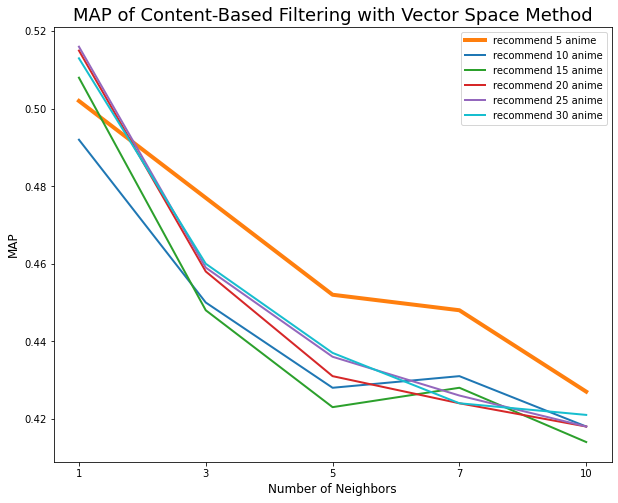

In [132]:
# Data
df=pd.DataFrame({'x_values': x_axis_cbv, 'y1_values': map_5_cbv, 'y2_values': map_10_cbv, 'y3_values': map_15_cbv,
                'y4_values':map_20_cbv,'y5_values':map_25_cbv,'y6_values':map_30_cbv})
# fig size
plt.figure(figsize=(10,8))
# multiple line plots
plt.plot( 'x_values', 'y1_values', data=df, marker='', color='tab:orange', linewidth=4,label='recommend 5 anime')
plt.plot( 'x_values', 'y2_values', data=df, marker='', color='tab:blue', linewidth=2,label='recommend 10 anime')
plt.plot( 'x_values', 'y3_values', data=df, marker='', color='tab:green', linewidth=2,label='recommend 15 anime')
plt.plot( 'x_values', 'y4_values', data=df, marker='', color='tab:red', linewidth=2,label='recommend 20 anime')
plt.plot( 'x_values', 'y5_values', data=df, marker='', color='tab:purple', linewidth=2,label='recommend 25 anime')
plt.plot( 'x_values', 'y6_values', data=df, marker='', color='tab:cyan', linewidth=2,label='recommend 30 anime')

# set x axis label
plt.xlabel('Number of Neighbors',fontsize=12)
# Set the y axis label 
plt.ylabel('MAP',fontsize=12)
# Set a title of the current axes.
plt.title('MAP of Content-Based Filtering with Vector Space Method',fontsize=18)

# show legend
plt.legend()

# show graph
plt.show()

## 4.2 MAP: Content-based NN Model

In [133]:
# map values are generated from above evaluation funciton and recorded
map_5_cbn=[0.57196,0.52727,0.5181,0.479545,0.48863]
map_10_cbn=[0.54924,0.5409,0.509,0.48295,0.48522]
map_15_cbn=[0.54696,0.5336,0.51136,0.4856,0.48863]
map_20_cbn=[0.54981,0.53343,0.5164,0.49545,0.484659]
map_25_cbn=[0.55562,0.536047,0.51776,0.49967,0.49454]
map_30_cbn=[0.55767,0.536653,0.51935,0.50247,0.4928]

x_axis_cbv=['1','3','5','7','10']

In [134]:
# round all to 3 decimal points
map_5_cbn=[round(x,3) for x in map_5_cbn]
map_10_cbn=[round(x,3) for x in map_10_cbn]
map_15_cbn=[round(x,3) for x in map_15_cbn]
map_20_cbn=[round(x,3) for x in map_20_cbn]
map_25_cbn=[round(x,3) for x in map_25_cbn]
map_30_cbn=[round(x,3) for x in map_30_cbn]

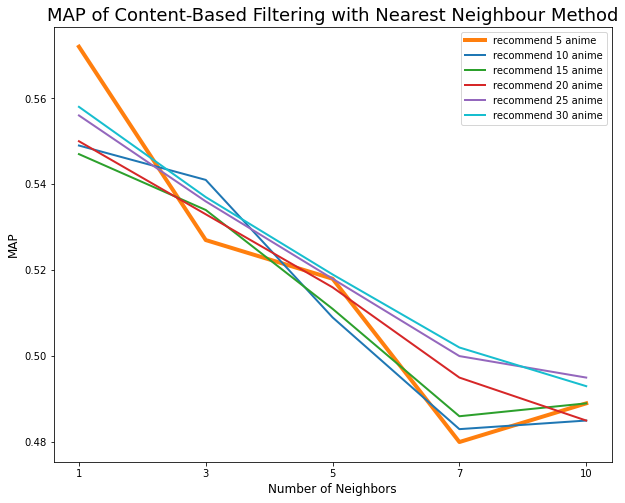

In [137]:
# Data
df1=pd.DataFrame({'x_values': x_axis_cbv, 'y1_values': map_5_cbn, 'y2_values': map_10_cbn, 'y3_values': map_15_cbn,
                'y4_values':map_20_cbn,'y5_values':map_25_cbn,'y6_values':map_30_cbn})
# fig size
plt.figure(figsize=(10,8))
# multiple line plots
plt.plot( 'x_values', 'y1_values', data=df1, marker='', color='tab:orange', linewidth=4,label='recommend 5 anime')
plt.plot( 'x_values', 'y2_values', data=df1, marker='', color='tab:blue', linewidth=2,label='recommend 10 anime')
plt.plot( 'x_values', 'y3_values', data=df1, marker='', color='tab:green', linewidth=2,label='recommend 15 anime')
plt.plot( 'x_values', 'y4_values', data=df1, marker='', color='tab:red', linewidth=2,label='recommend 20 anime')
plt.plot( 'x_values', 'y5_values', data=df1, marker='', color='tab:purple', linewidth=2,label='recommend 25 anime')
plt.plot( 'x_values', 'y6_values', data=df1, marker='', color='tab:cyan', linewidth=2,label='recommend 30 anime')

# set x axis label
plt.xlabel('Number of Neighbors',fontsize=12)
# Set the y axis label 
plt.ylabel('MAP',fontsize=12)
# Set a title of the current axes.
plt.title('MAP of Content-Based Filtering with Nearest Neighbour Method',fontsize=18)

# show legend
plt.legend()

# show graph
plt.show()

## 4.3 MAP: User-based Collaborative Filtering Model

In [138]:
# map values are generated from above evaluation funciton and recorded
map_5_ub=[0.68538,0.7681,0.78181,0.781818,0.7999]
map_10_ub=[0.68446,0.75,0.767,0.76818,0.78409]
map_15_ub=[0.684174,0.74394,0.75833,0.767424,0.7689]
map_20_ub=[0.67899,0.7392,0.75113,0.75738,0.7585]
map_25_ub=[0.67,0.7309,0.74636,0.7445,0.75181]
map_30_ub=[0.66748,0.726906,0.7409,0.7409,0.74962]

x_axis_ub=['1','3','5','7','10']

In [139]:
# round all to 3 decimal points
map_5_ub=[round(x,3) for x in map_5_ub]
map_10_ub=[round(x,3) for x in map_10_ub]
map_15_ub=[round(x,3) for x in map_15_ub]
map_20_ub=[round(x,3) for x in map_20_ub]
map_25_ub=[round(x,3) for x in map_25_ub]
map_30_ub=[round(x,3) for x in map_30_ub]

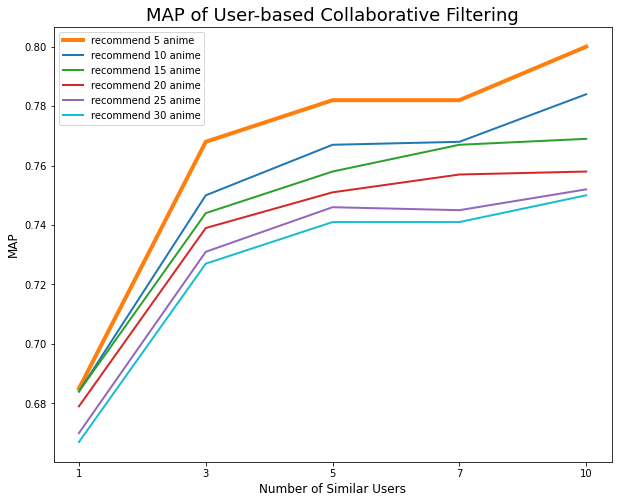

In [141]:
# Data
df2=pd.DataFrame({'x_values': x_axis_cbv, 'y1_values': map_5_ub, 'y2_values': map_10_ub, 'y3_values': map_15_ub,
                'y4_values':map_20_ub,'y5_values':map_25_ub,'y6_values':map_30_ub})
# fig sizeub
plt.figure(figsize=(10,8))
# multiple line plots
plt.plot( 'x_values', 'y1_values', data=df2, marker='', color='tab:orange', linewidth=4,label='recommend 5 anime')
plt.plot( 'x_values', 'y2_values', data=df2, marker='', color='tab:blue', linewidth=2,label='recommend 10 anime')
plt.plot( 'x_values', 'y3_values', data=df2, marker='', color='tab:green', linewidth=2,label='recommend 15 anime')
plt.plot( 'x_values', 'y4_values', data=df2, marker='', color='tab:red', linewidth=2,label='recommend 20 anime')
plt.plot( 'x_values', 'y5_values', data=df2, marker='', color='tab:purple', linewidth=2,label='recommend 25 anime')
plt.plot( 'x_values', 'y6_values', data=df2, marker='', color='tab:cyan', linewidth=2,label='recommend 30 anime')

# set x axis label
plt.xlabel('Number of Similar Users',fontsize=12)
# Set the y axis label 
plt.ylabel('MAP',fontsize=12)
# Set a title of the current axes.
plt.title('MAP of User-based Collaborative Filtering',fontsize=18)

# show legend
plt.legend()

# show graph
plt.show()

## 4.4 MAP: Item-based Collaborative Filtering Model

In [142]:
# map values are generated from above evaluation funciton and recorded
map_5_ib=[0.6262,0.6409,0.5795,0.58409,0.5818]
map_10_ib=[0.54204,0.62623,0.5942,0.58295,0.5647]
map_15_ib=[0.52954,0.6356,0.5998,0.5916,0.57954]
map_20_ib=[0.5375,0.6318,0.610064,0.58863,0.5795]
map_25_ib=[0.55045,0.62183,0.61166,0.59136,0.57909]
map_30_ib=[0.54242,0.62215,0.612756,0.59583,0.58371]

x_axis_ub=['1','3','5','7','10']

In [143]:
# round all to 3 decimal points
map_5_ib=[round(x,3) for x in map_5_ib]
map_10_ib=[round(x,3) for x in map_10_ib]
map_15_ib=[round(x,3) for x in map_15_ib]
map_20_ib=[round(x,3) for x in map_20_ib]
map_25_ib=[round(x,3) for x in map_25_ib]
map_30_ib=[round(x,3) for x in map_30_ib]

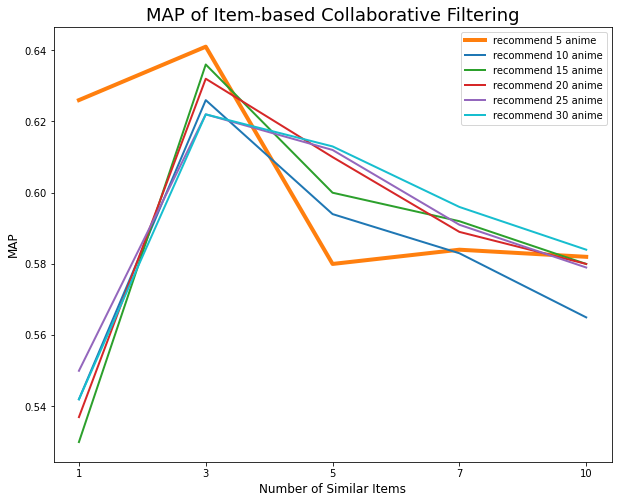

In [144]:
# Data
df3=pd.DataFrame({'x_values': x_axis_cbv, 'y1_values': map_5_ib, 'y2_values': map_10_ib, 'y3_values': map_15_ib,
                'y4_values':map_20_ib,'y5_values':map_25_ib,'y6_values':map_30_ib})
# fig sizeub
plt.figure(figsize=(10,8))
# multiple line plots
plt.plot( 'x_values', 'y1_values', data=df3, marker='', color='tab:orange', linewidth=4,label='recommend 5 anime')
plt.plot( 'x_values', 'y2_values', data=df3, marker='', color='tab:blue', linewidth=2,label='recommend 10 anime')
plt.plot( 'x_values', 'y3_values', data=df3, marker='', color='tab:green', linewidth=2,label='recommend 15 anime')
plt.plot( 'x_values', 'y4_values', data=df3, marker='', color='tab:red', linewidth=2,label='recommend 20 anime')
plt.plot( 'x_values', 'y5_values', data=df3, marker='', color='tab:purple', linewidth=2,label='recommend 25 anime')
plt.plot( 'x_values', 'y6_values', data=df3, marker='', color='tab:cyan', linewidth=2,label='recommend 30 anime')

# set x axis label
plt.xlabel('Number of Similar Items',fontsize=12)
# Set the y axis label 
plt.ylabel('MAP',fontsize=12)
# Set a title of the current axes.
plt.title('MAP of Item-based Collaborative Filtering',fontsize=18)

# show legend
plt.legend()

# show graph
plt.show()

## 4.5 MAP between Models

### 4.5.1 Fix number of neighbors

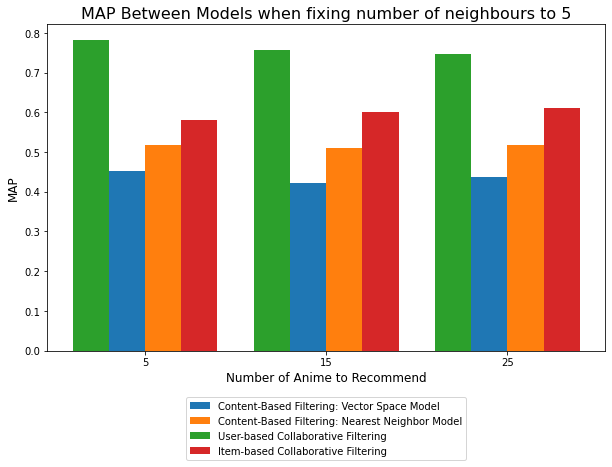

In [147]:
# fix number of neighbours to 5
cbv=[0.45227,0.423484,0.43559]
cbn=[0.5181,0.51136,0.51776]
ub=[0.78181,0.75833,0.74636]
it=[0.5795,0.5998,0.61166]

# round
cbv=[round(x,3) for x in cbv]
cbn=[round(x,3) for x in cbn]
ub=[round(x,3) for x in ub]
it=[round(x,3) for x in it]

# plot figure
plt.figure(figsize=(10,6))

x_axis_name = [5,15,25]

X_axis = np.arange(len(x_axis_name))
  
plt.bar(X_axis - 0.1, cbv, 0.2, label = 'Content-Based Filtering: Vector Space Model')
plt.bar(X_axis + 0.1, cbn, 0.2, label = 'Content-Based Filtering: Nearest Neighbor Model')
plt.bar(X_axis - 0.3, ub, 0.2, label = 'User-based Collaborative Filtering')
plt.bar(X_axis + 0.3, it, 0.2, label = 'Item-based Collaborative Filtering')

plt.xticks(X_axis, x_axis_name)
plt.xlabel("Number of Anime to Recommend",fontsize=12)
plt.ylabel("MAP",fontsize=12)
plt.title("MAP Between Models when fixing number of neighbours to 5",fontsize=16)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.35))

fig.subplots_adjust(bottom=0.25)
plt.show()

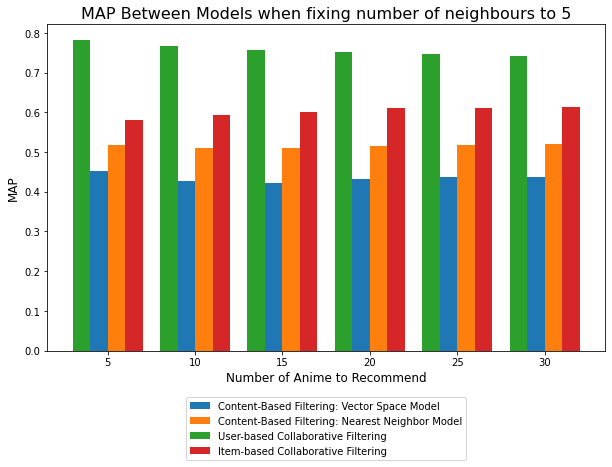

In [148]:
# fix number of neighbours to 5: this code will show more results
cbv=[0.45227,0.4284,0.423484,0.431279,0.43559,0.4366]
cbn=[0.5181,0.509,0.51136,0.5164,0.51776,0.51935]
ub=[0.78181,0.767,0.75833,0.75113,0.74636,0.7409]
it=[0.5795,0.5942,0.5998,0.610064,0.61166,0.612756]

# round
cbv=[round(x,3) for x in cbv]
cbn=[round(x,3) for x in cbn]
ub=[round(x,3) for x in ub]
it=[round(x,3) for x in it]

# plot figure
plt.figure(figsize=(10,6))

x_axis_name = [5,10,15,20,25,30]

X_axis = np.arange(len(x_axis_name))
  
plt.bar(X_axis - 0.1, cbv, 0.2, label = 'Content-Based Filtering: Vector Space Model')
plt.bar(X_axis + 0.1, cbn, 0.2, label = 'Content-Based Filtering: Nearest Neighbor Model')
plt.bar(X_axis - 0.3, ub, 0.2, label = 'User-based Collaborative Filtering')
plt.bar(X_axis + 0.3, it, 0.2, label = 'Item-based Collaborative Filtering')

plt.xticks(X_axis, x_axis_name)
plt.xlabel("Number of Anime to Recommend",fontsize=12)
plt.ylabel("MAP",fontsize=12)
plt.title("MAP Between Models when fixing number of neighbours to 5",fontsize=16)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.35))

fig.subplots_adjust(bottom=0.25)
plt.show()

### 4.5.2 Fix number of anime

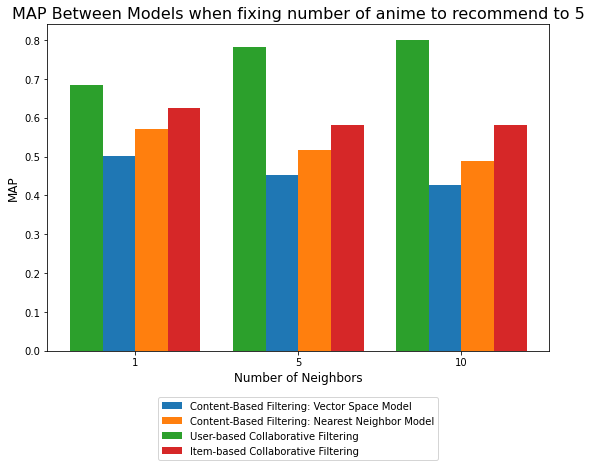

In [149]:
# fix number of anime to 5

cbv1=[0.50227,0.45227,0.42727]
cbn1=[0.57196,0.5181,0.48863]
ub1=[0.68538,0.78181,0.7999]
it1=[0.6262,0.5795,0.5818]

# round
cbv1=[round(x,3) for x in cbv1]
cbn1=[round(x,3) for x in cbn1]
ub1=[round(x,3) for x in ub1]
it1=[round(x,3) for x in it1]

# plot figure
plt.figure(figsize=(9,6))

x_axis_name = ["1","5","10"]

X_axis = np.arange(len(x_axis_name))
  
plt.bar(X_axis - 0.1, cbv1, 0.2, label = 'Content-Based Filtering: Vector Space Model')
plt.bar(X_axis + 0.1, cbn1, 0.2, label = 'Content-Based Filtering: Nearest Neighbor Model')
plt.bar(X_axis - 0.3, ub1, 0.2, label = 'User-based Collaborative Filtering')
plt.bar(X_axis + 0.3, it1, 0.2, label = 'Item-based Collaborative Filtering')

plt.xticks(X_axis, x_axis_name)
plt.xlabel("Number of Neighbors",fontsize=12)
plt.ylabel("MAP",fontsize=12)
plt.title("MAP Between Models when fixing number of anime to recommend to 5",fontsize=16)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.35))

fig.subplots_adjust(bottom=0.25)
plt.show()

# 5. Diversity Comparison & Visualization

The way of measuring genre diversity is to measure how many out-of-box recommendations are suggested. Here, the dissertation defines genre that is not within the top 10 genre list as out-of-box genre: Any recommendations that hit out-of-box genre is defined as an out-of-box genre recommendation. 

## 5.1 Diversity: CB vector Space

In [150]:
# check recommendation diversity for the first user
rec_list=[]
for each_anime in relevant_anime_for_user(0):
    rec_list.append(list(get_recommendations(each_anime,5)))

In [151]:
rec_list_break = []
for l in rec_list:
    for x in l:       
        for element in x.split(','):
            rec_list_break.append(element)

In [152]:
genders_cbv_break = []

genders_cbv = []
for name in rec_list_break[187:]:
    find_row=df_anime_final.loc[df_anime_final["Name"]==name,"Genders"]
    genders_cbv.append(list(find_row))
for l in genders_cbv:
    for x in l:  
        genders_cbv_break.append(list(x.split(','))[0])

        try:
            genders_cbv_break.append(list(x.split(','))[1]) 
            genders_cbv_break.append(list(x.split(','))[2])
        except:
            pass

cbv_data=Counter(genders_cbv_break)
cbv_data_df=pd.DataFrame(cbv_data.items(), columns=['Genre','Frequency_cbv'])
cbv_data_df["Frequency_cbv"] = pd.to_numeric(cbv_data_df["Frequency_cbv"])

In [153]:
cbv_data_df=cbv_data_df.sort_values("Frequency_cbv",ascending=False)

In [154]:
cbv_data_df["outofbox"]=np.where(cbv_data_df["Genre"].isin(["Comedy","Action","Fantasy","Adventure",
                                                          "Kids","Drama","Sci-Fi","Music","Shounen","SliceofLife"]),0,1)

In [155]:
cbv_data_df["count_outofbox"]=cbv_data_df["Frequency_cbv"]*cbv_data_df["outofbox"]

In [156]:
cbv_data_df=cbv_data_df.loc[cbv_data_df["count_outofbox"]!=0]

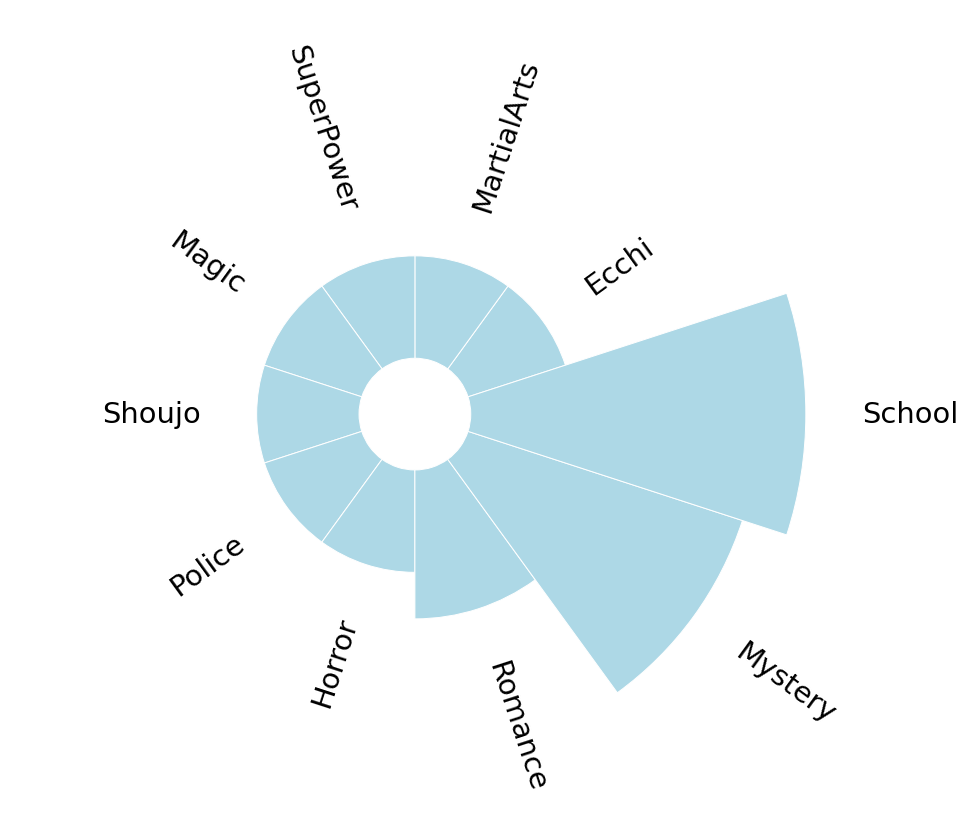

In [157]:

# Reorder the dataframe
cbv_data_df = cbv_data_df.sort_values(by=['count_outofbox'])

# initialize the figure
plt.figure(figsize=(25,15))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 10
lowerLimit = 1
labelPadding = 1

# Compute max and min in the dataset
max = cbv_data_df['count_outofbox'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates

slope = (max - lowerLimit) / max
heights = slope * cbv_data_df.count_outofbox + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(cbv_data_df.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(cbv_data_df.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=1, 
    edgecolor="white",
    color="lightblue",
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, cbv_data_df["Genre"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor",fontsize=29)

## 5.2 Diversity: CB NN Model

In [169]:
# check recommendation diversity for the first user
rec_list_nn=[]
for each_anime in relevant_anime_for_user(0):
    rec_list_nn.append(list(print_similar_animes(each_anime)))
    
rec_list_break_nn = []
for l in rec_list_nn:
    for x in l:       
        for element in x.split(','):
            rec_list_break_nn.append(element)

In [170]:
genders_nn_break = []

genders_nn = []
for name in rec_list_break_nn[187:]:
    find_row=df_anime_final.loc[df_anime_final["Name"]==name,"Genders"]
    genders_nn.append(list(find_row))
for l in genders_nn:
    for x in l:  
        genders_nn_break.append(list(x.split(','))[0])

        try:
            genders_nn_break.append(list(x.split(','))[1]) 
            genders_nn_break.append(list(x.split(','))[2])
        except:
            pass

nn_data=Counter(genders_nn_break)
nn_data_df=pd.DataFrame(nn_data.items(), columns=['Genre','Frequency_nn'])
nn_data_df["Frequency_nn"] = pd.to_numeric(nn_data_df["Frequency_nn"])

In [171]:
nn_data_df=nn_data_df.sort_values("Frequency_nn",ascending=False)
nn_data_df["outofbox"]=np.where(nn_data_df["Genre"].isin(["Comedy","Action","Fantasy","Adventure",
                                                          "Kids","Drama","Sci-Fi","Music","Shounen","SliceofLife"]),0,1)
nn_data_df["count_outofbox"]=nn_data_df["Frequency_nn"]*nn_data_df["outofbox"]
nn_data_df=nn_data_df.loc[nn_data_df["count_outofbox"]!=0]

In [172]:
nn_data_df

Genre  Frequency_nn  outofbox  count_outofbox
8        Mystery             4         1               4
3         Sports             3         1               3
6     Historical             3         1               3
9         Police             2         1               2
13        School             2         1               2
15         Magic             2         1               2
7   Supernatural             1         1               1
11         Josei             1         1               1
14         Ecchi             1         1               1

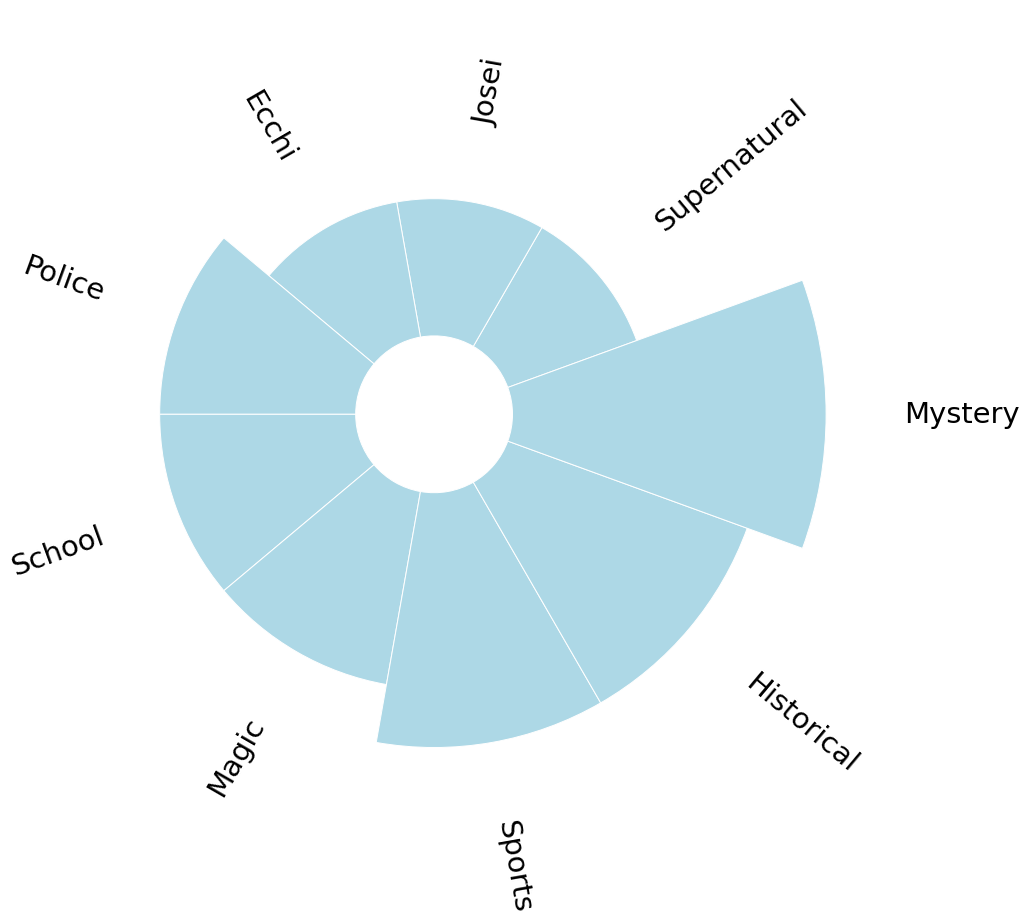

In [173]:
# Reorder the dataframe
nn_data_df = nn_data_df.sort_values(by=['count_outofbox'])

# initialize the figure
plt.figure(figsize=(25,15))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 10
lowerLimit = 1
labelPadding = 1

# Compute max and min in the dataset
max = nn_data_df['count_outofbox'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates

slope = (max - lowerLimit) / max
heights = slope * nn_data_df.count_outofbox + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(nn_data_df.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(nn_data_df.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=1, 
    edgecolor="white",
    color="lightblue",
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, nn_data_df["Genre"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor",fontsize=29)

## 5.3 Diversity: CF User-based

In [174]:
# ub
genders_ub_break = []


genders_ub = []
for name in list(find_anime_cf_user(1,5,30)):
    find_row=df_anime_final.loc[df_anime_final["Name"]==name,"Genders"]
    genders_ub.append(list(find_row))

for l in genders_ub:
    for x in l:  
        genders_ub_break.append(list(x.split(','))[0])

        try:
            genders_ub_break.append(list(x.split(','))[1]) 
            genders_ub_break.append(list(x.split(','))[2])
        except:
            pass

ub_data=Counter(genders_ub_break)
ub_data_df=pd.DataFrame(ub_data.items(), columns=['Genre','Frequency_ub'])
ub_data_df["Frequency_ub"] = pd.to_numeric(ub_data_df["Frequency_ub"])

In [175]:
ub_data_df=ub_data_df.sort_values("Frequency_ub",ascending=False)

In [176]:
ub_data_df["outofbox"]=np.where(ub_data_df["Genre"].isin(["Comedy","Action","Fantasy","Adventure",
                                                          "Kids","Drama","Sci-Fi","Music","Shounen","SliceofLife"]),0,1)

In [177]:
ub_data_df["count_outofbox"]=ub_data_df["Frequency_ub"]*ub_data_df["outofbox"]

In [178]:
ub_data_df=ub_data_df.loc[ub_data_df["count_outofbox"]!=0]

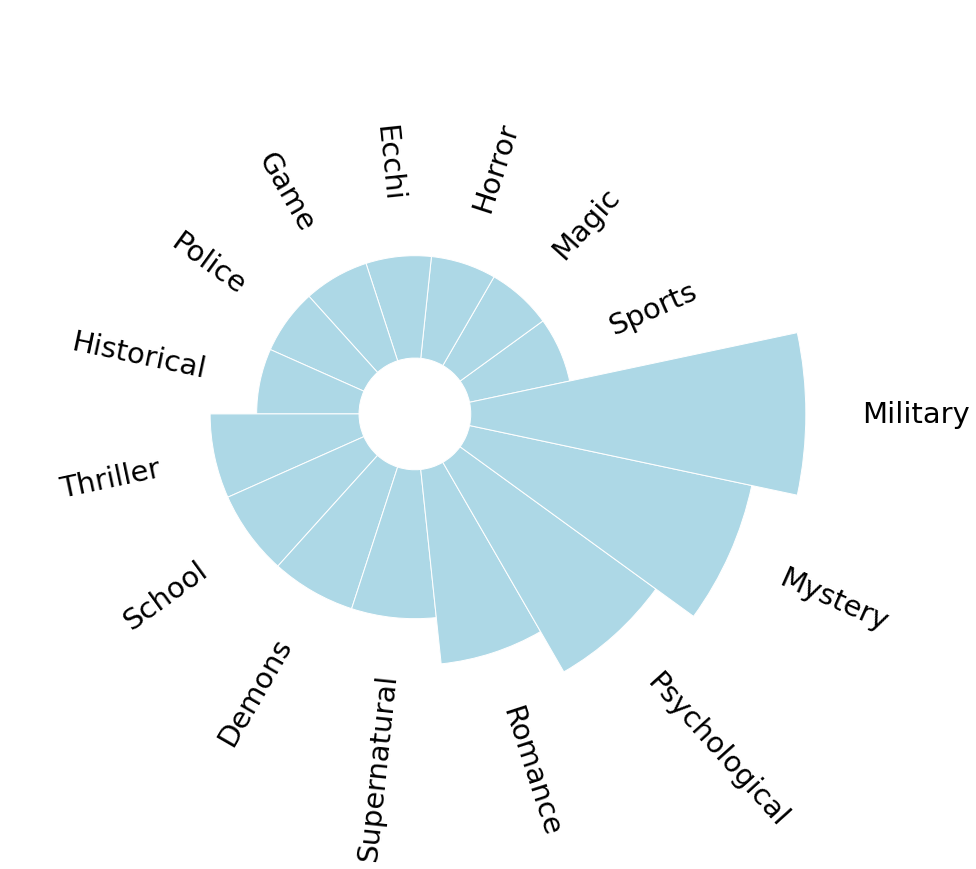

In [179]:

# Reorder the dataframe
ub_data_df = ub_data_df.sort_values(by=['count_outofbox'])

# initialize the figure
plt.figure(figsize=(25,15))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 10
lowerLimit = 1
labelPadding = 1

# Compute max and min in the dataset
max = ub_data_df['count_outofbox'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates

slope = (max - lowerLimit) / max
heights = slope * ub_data_df.count_outofbox + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(ub_data_df.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(ub_data_df.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=1, 
    edgecolor="white",
    color="lightblue",
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, ub_data_df["Genre"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor",fontsize=29)

## 5.4 Diversity: CF Item-based

In [180]:
# it
genders_it_break = []


genders_it = []
for name in list(recommend_anime_item(0,1,30)):
    find_row=df_anime_final.loc[df_anime_final["Name"]==name,"Genders"]
    genders_it.append(list(find_row))

for l in genders_it:
    for x in l:  
        genders_it_break.append(list(x.split(','))[0])

        try:
            genders_it_break.append(list(x.split(','))[1]) 
            genders_it_break.append(list(x.split(','))[2])
        except:
            pass

it_data=Counter(genders_it_break)
it_data_df=pd.DataFrame(it_data.items(), columns=['Genre','Frequency_it'])
it_data_df["Frequency_it"] = pd.to_numeric(it_data_df["Frequency_it"])

In [181]:
it_data_df=it_data_df.sort_values("Frequency_it",ascending=False)
it_data_df["outofbox"]=np.where(it_data_df["Genre"].isin(["Comedy","Action","Fantasy","Adventure",
                                                          "Kids","Drama","Sci-Fi","Music","Shounen","SliceofLife"]),0,1)
it_data_df["count_outofbox"]=it_data_df["Frequency_it"]*it_data_df["outofbox"]
it_data_df=it_data_df.loc[it_data_df["count_outofbox"]!=0]

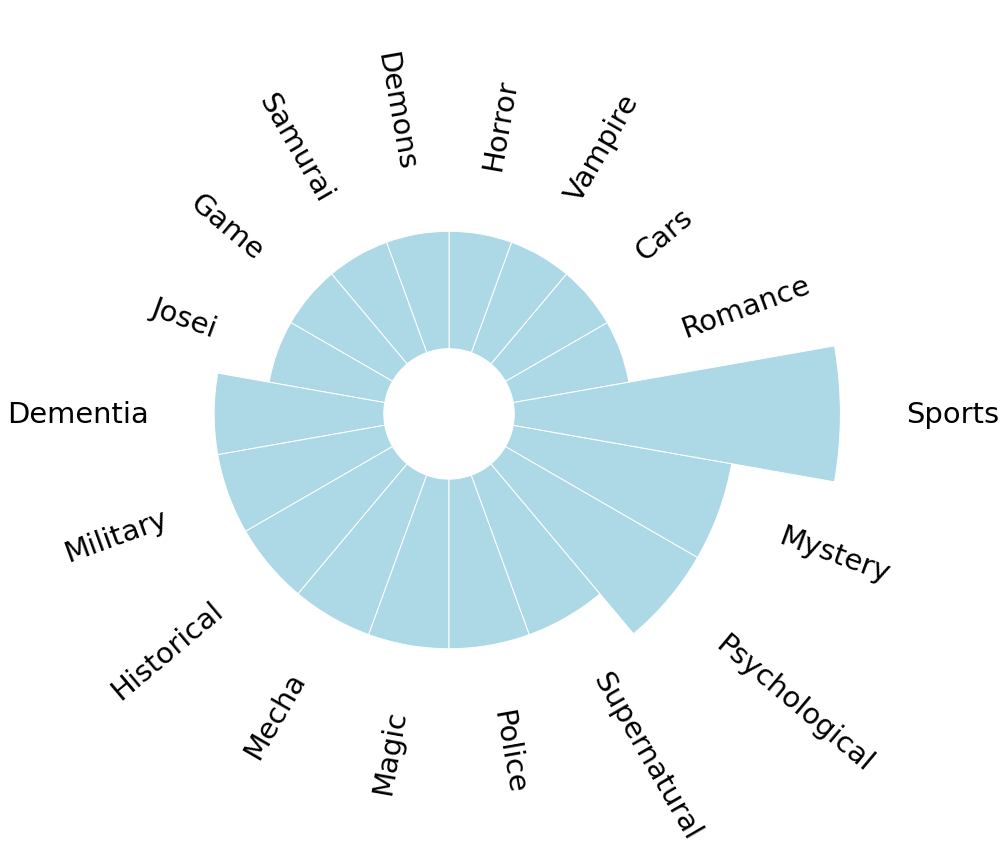

In [182]:
# Reorder the dataframe
it_data_df = it_data_df.sort_values(by=['count_outofbox'])

# initialize the figure
plt.figure(figsize=(25,15))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 10
lowerLimit = 1
labelPadding = 1

# Compute max and min in the dataset
max = it_data_df['count_outofbox'].max()

# Let's compute heights: they are a conversion of each item value in those new coordinates

slope = (max - lowerLimit) / max
heights = slope * it_data_df.count_outofbox + lowerLimit

# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(it_data_df.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(it_data_df.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=1, 
    edgecolor="white",
    color="lightblue",
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, it_data_df["Genre"]):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, 
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor",fontsize=29)

## 5.5 Model Comparison: out-of-box genre comparison

In [183]:
cbv_data_df_new=cbv_data_df[["Genre","count_outofbox"]]
nn_data_df_new=nn_data_df[["Genre","count_outofbox"]]
ub_data_df_new=ub_data_df[["Genre","count_outofbox"]]
it_data_df_new=it_data_df[["Genre","count_outofbox"]]


In [184]:
cbv_data_df_new=cbv_data_df_new.rename(columns={"count_outofbox":"count_cbv"})

In [185]:
nn_data_df_new=nn_data_df_new.rename(columns={"count_outofbox":"count_nn"})

In [186]:
ub_data_df_new=ub_data_df_new.rename(columns={"count_outofbox":"count_ub"})

In [187]:
it_data_df_new=it_data_df_new.rename(columns={"count_outofbox":"count_it"})

In [188]:
div_final=cbv_data_df_new.merge(nn_data_df_new, how='outer').merge(ub_data_df_new, how='outer').merge(it_data_df_new, how='outer')

In [189]:
div_final.fillna(0)

Genre  count_cbv  count_nn  count_ub  count_it
0           Ecchi        1.0       1.0       1.0       0.0
1     MartialArts        1.0       0.0       0.0       0.0
2      SuperPower        1.0       0.0       0.0       0.0
3           Magic        1.0       2.0       1.0       2.0
4          Shoujo        1.0       0.0       0.0       0.0
5          Police        1.0       2.0       1.0       2.0
6          Horror        1.0       0.0       1.0       1.0
7         Romance        2.0       0.0       3.0       1.0
8         Mystery        5.0       4.0       5.0       3.0
9          School        6.0       2.0       2.0       0.0
10   Supernatural        0.0       1.0       2.0       2.0
11          Josei        0.0       1.0       0.0       1.0
12         Sports        0.0       3.0       1.0       5.0
13     Historical        0.0       3.0       1.0       2.0
14           Game        0.0       0.0       1.0       1.0
15       Thriller        0.0       0.0       2.0       0.0
16         Demons        0.0       0.0       2.0       1.0
17  Psychological        0.0       0.0       4.0       3.0
18       Military        0.0       0.0       6.0       2.0
19           Cars        0.0       0.0       0.0       1.0
20        Vampire        0.0       0.0       0.0       1.0
21        Samurai        0.0       0.0       0.0       1.0
22       Dementia        0.0       0.0       0.0       2.0
23          Mecha        0.0       0.0       0.0       2.0

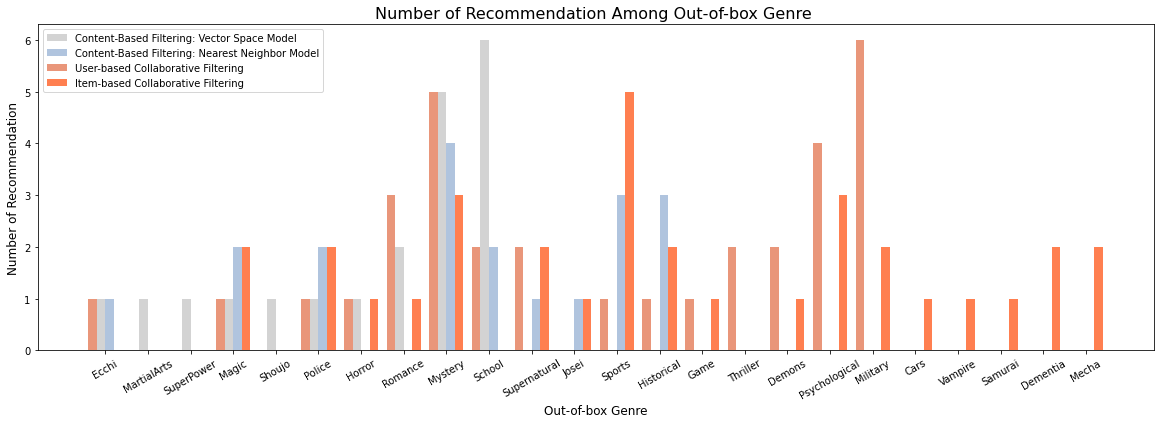

In [190]:
# plot figure
plt.figure(figsize=(20,6))

x_axis_name = list(div_final["Genre"])

X_axis = np.arange(len(x_axis_name))
  
plt.bar(X_axis - 0.1, div_final["count_cbv"], 0.2, label = 'Content-Based Filtering: Vector Space Model',color="lightgrey")
plt.bar(X_axis + 0.1, div_final["count_nn"], 0.2, label = 'Content-Based Filtering: Nearest Neighbor Model',color="lightsteelblue")
plt.bar(X_axis - 0.3, div_final["count_ub"], 0.2, label = 'User-based Collaborative Filtering',color="darksalmon")
plt.bar(X_axis + 0.3, div_final["count_it"], 0.2, label = 'Item-based Collaborative Filtering',color="coral")

plt.xticks(X_axis, x_axis_name,rotation=30)
plt.xlabel("Out-of-box Genre",fontsize=12)
plt.ylabel("Number of Recommendation",fontsize=12)
plt.title("Number of Recommendation Among Out-of-box Genre ",fontsize=16)
plt.legend()

plt.show()

# 6. Position (Focused MAP) Comparison

In [191]:
pos_three_all=[sum(acccuracy_three_cbv)/len(acccuracy_three_cbv),sum(acccuracy_three_nn)/len(acccuracy_three_nn),
              sum(acccuracy_three_ub)/len(acccuracy_three_ub),sum(acccuracy_three_it)/len(acccuracy_three_it)]
pos_five_all=[sum(acccuracy_five_cbv)/len(acccuracy_five_cbv),sum(acccuracy_five_nn)/len(acccuracy_five_nn),
              sum(acccuracy_five_ub)/len(acccuracy_five_ub),sum(acccuracy_five_it)/len(acccuracy_five_it)]

In [192]:
pos_three_all=[round(x,2) for x in pos_three_all]
pos_five_all=[round(x,2) for x in pos_five_all]

In [193]:
cbv_pos=[pos_three_all[0],pos_five_all[0]]
nn_pos=[pos_three_all[1],pos_five_all[1]]
ub_pos=[pos_three_all[2],pos_five_all[2]]
it_pos=[pos_three_all[3],pos_five_all[3]]

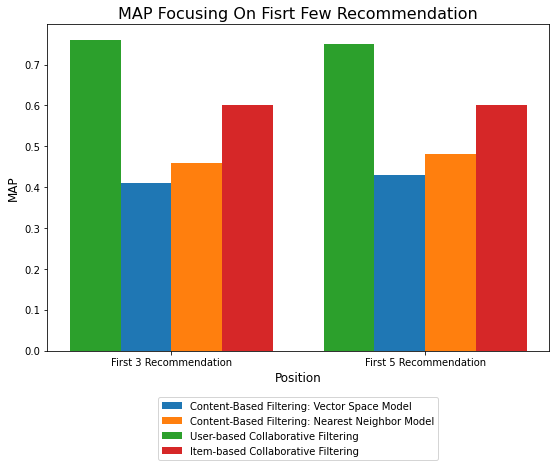

In [194]:
# plot figure
plt.figure(figsize=(9,6))

x_axis_name_pos = ["First 3 Recommendation","First 5 Recommendation"]

X_axis_pos = np.arange(len(x_axis_name_pos))
  
plt.bar(X_axis_pos - 0.1, cbv_pos, 0.2, label = 'Content-Based Filtering: Vector Space Model')
plt.bar(X_axis_pos + 0.1, nn_pos, 0.2, label = 'Content-Based Filtering: Nearest Neighbor Model')
plt.bar(X_axis_pos - 0.3, ub_pos, 0.2, label = 'User-based Collaborative Filtering')
plt.bar(X_axis_pos + 0.3, it_pos, 0.2, label = 'Item-based Collaborative Filtering')

plt.xticks(X_axis_pos, x_axis_name_pos)
plt.xlabel("Position",fontsize=12)
plt.ylabel("MAP",fontsize=12)
plt.title("MAP Focusing On Fisrt Few Recommendation",fontsize=16)
plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.35))

fig.subplots_adjust(bottom=0.25)
plt.show()

#  Credits

Data extraced from Kaggle: https://www.kaggle.com/hernan4444/anime-recommendation-database-2020

References are listed in the original dissertation paper.